In [60]:
import copy
import os
import pickle as pkl
import sys
import dataclasses

import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy as sp
from fusiondls import MagneticGeometry, SimulationInputs, file_read, file_write, run_dls
from fusiondls.analytic_cooling_curves import LfuncKallenbach
from fusiondls.Profile import Profile
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from netCDF4 import Dataset
from scipy import interpolate

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors

from DLS.postprocess import *

change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read SOLPS case

In [7]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [8]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [9]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            # eqb[case][side][i] = unpackConfigurationMK(
            #     File = os.path.join(balance_paths[case], "balance.nc"), Type = side, sepadd=i, 
            #     resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)

            eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Cooling curve work

In [10]:
rd_N = xr.open_dataset(r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\nitrogen.nc")
rd_Ar = xr.open_dataset(r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

## ADAS interpolation

Text(0.5, 1.0, 'Interpolated N curves')

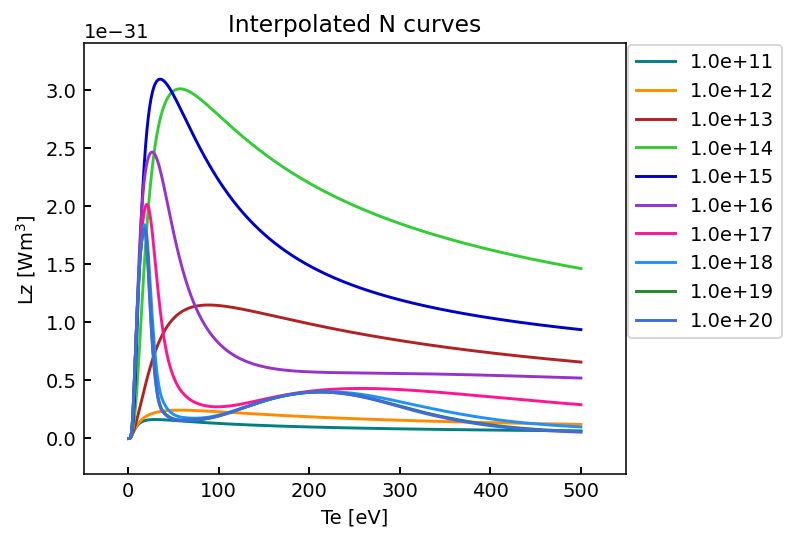

In [11]:
curves = {}
curves["Ar"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["Ar"][netau_name] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )

temps_interp = np.linspace(1, 500, 1000)

fig, ax = plt.subplots()
for netau in curves["Ar"].keys():
    ax.plot(temps_interp, [curves["Ar"][netau](T) for T in temps_interp], label = f"{netau:.1e}")
    
ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
# ax.set_xlim(0,2)
# ax.set_ylim(0,1e-35)
# ax.set_yscale("log")
ax.set_xlabel("Te [eV]")
ax.set_ylabel("Lz [$Wm^{3}$]")
ax.set_title("Interpolated N curves")

### Paper plot - outer

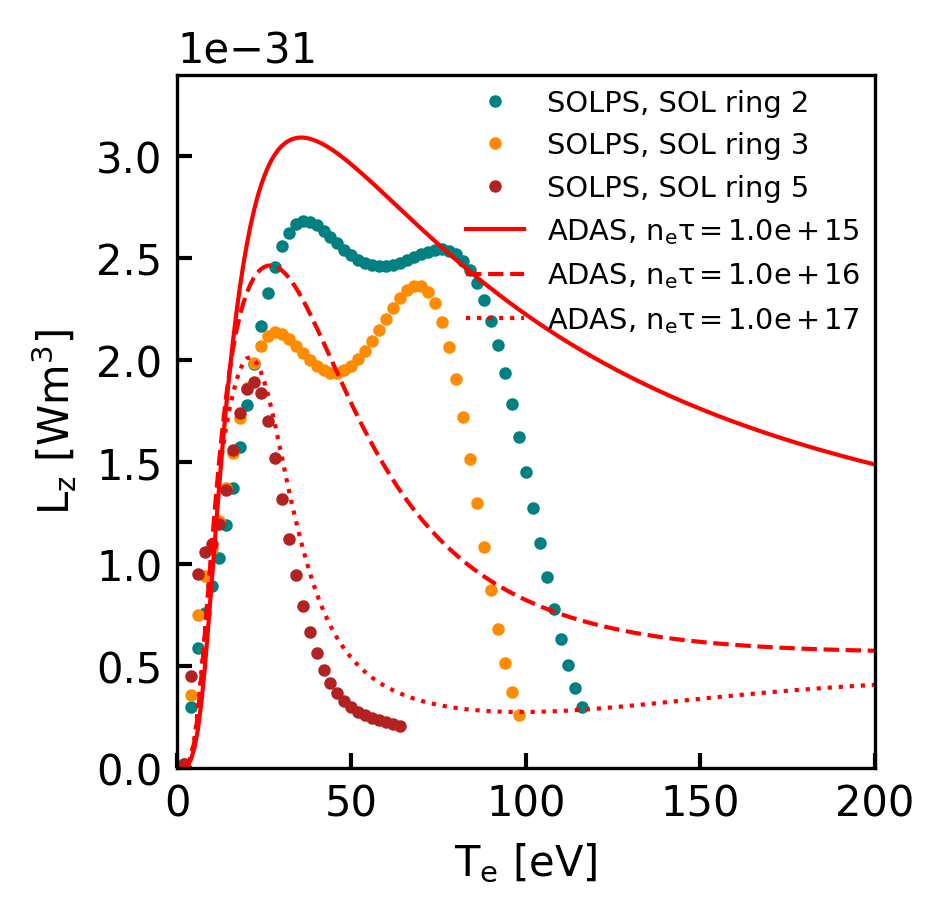

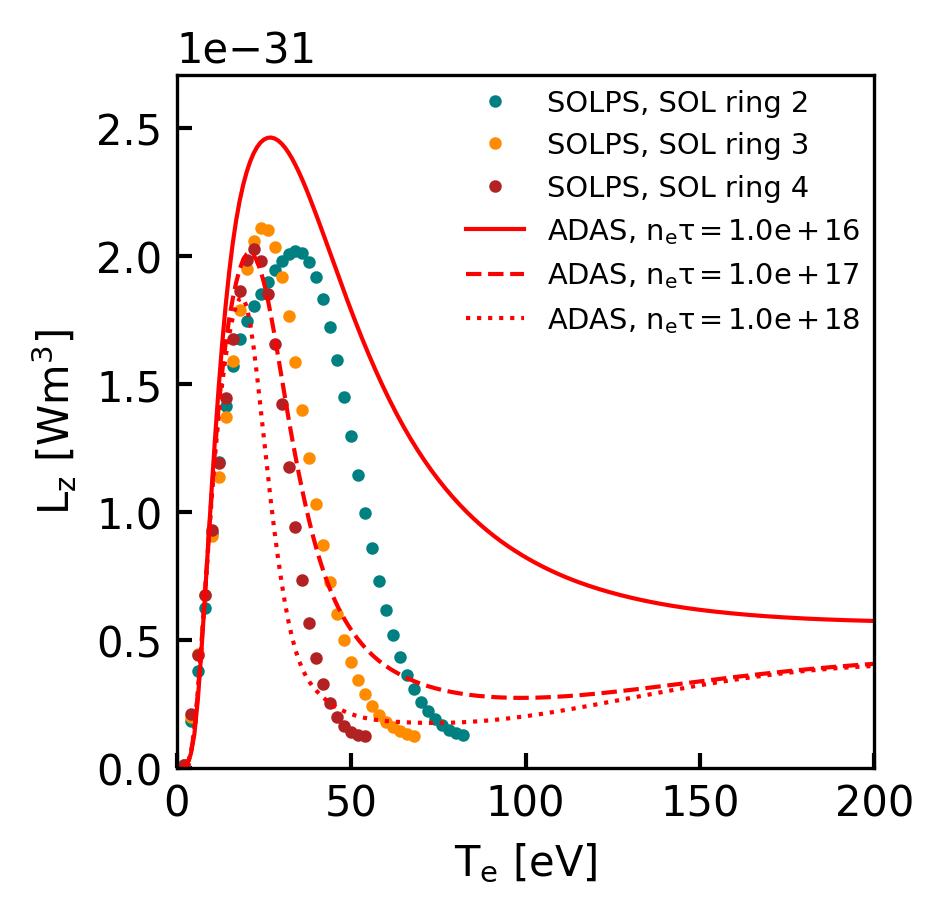

In [12]:
ring_choice = dict(outer_lower = [1,2,4], inner_lower = [1,2,3])

for region in ["outer_lower", "inner_lower"]:
# for region in ["inner_lower"]:

    species = "Ar"

    fig, ax = plt.subplots(figsize = (3,3), dpi = 300)

    Tlo = 1
    Thi = 500

    T = np.linspace(Tlo, Thi, 500)

    df_curves = []
    for i in ring_choice[region]:
        slc = store_slc[case]
        fun = slc.extract_cooling_curve(species, region, sepadd = i, order = 9, plot = False)

        Lz = [fun(temp) for temp in T]
        
        df_curve = pd.DataFrame()
        df_curve["T"] = T
        df_curve["Lz"] = Lz
        df_curve = df_curve[df_curve["Lz"] > 0]
        df_curves.append(df_curve)
        ax.plot(df_curve["T"][::2], df_curve["Lz"][::2], marker = "o", ms = 2, lw = 0, label = "SOLPS, " + "SOL ring " + str(i+1))
        
    linestyles = ["-", "--", ":"]
    
    if "inner" in region:
        netau_choice = [1e16, 1e17, 1e18]
    elif "outer" in region:
        netau_choice = [1e15, 1e16, 1e17]

    for i, netau in enumerate(netau_choice):
        ax.plot(T, [curves["Ar"][netau](temp) for temp in T], label = rf"ADAS, $n_{{e}}\tau={netau:.1e}$", c = "r", lw = 1, ls = linestyles[i])
    ax.legend(loc = "upper right", ncols = 1, bbox_to_anchor=(1, 1),fontsize = "x-small",  frameon = False)
    ax.set_xlim(0,200)
    ax.set_ylim(0,None)
    ax.set_xlabel("$T_e$ [eV]")
    ax.set_ylabel("$L_{z}$ [$Wm^{3}$]")
    ax.grid(which = "both", visible = False)
    # ax.set_title("Cross-case Lz comparison to ADAS")
    # plt.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_coolingcurves_{region}.pdf", format = "pdf", bbox_inches = "tight")

# Choosing SOL ring

## Power balance

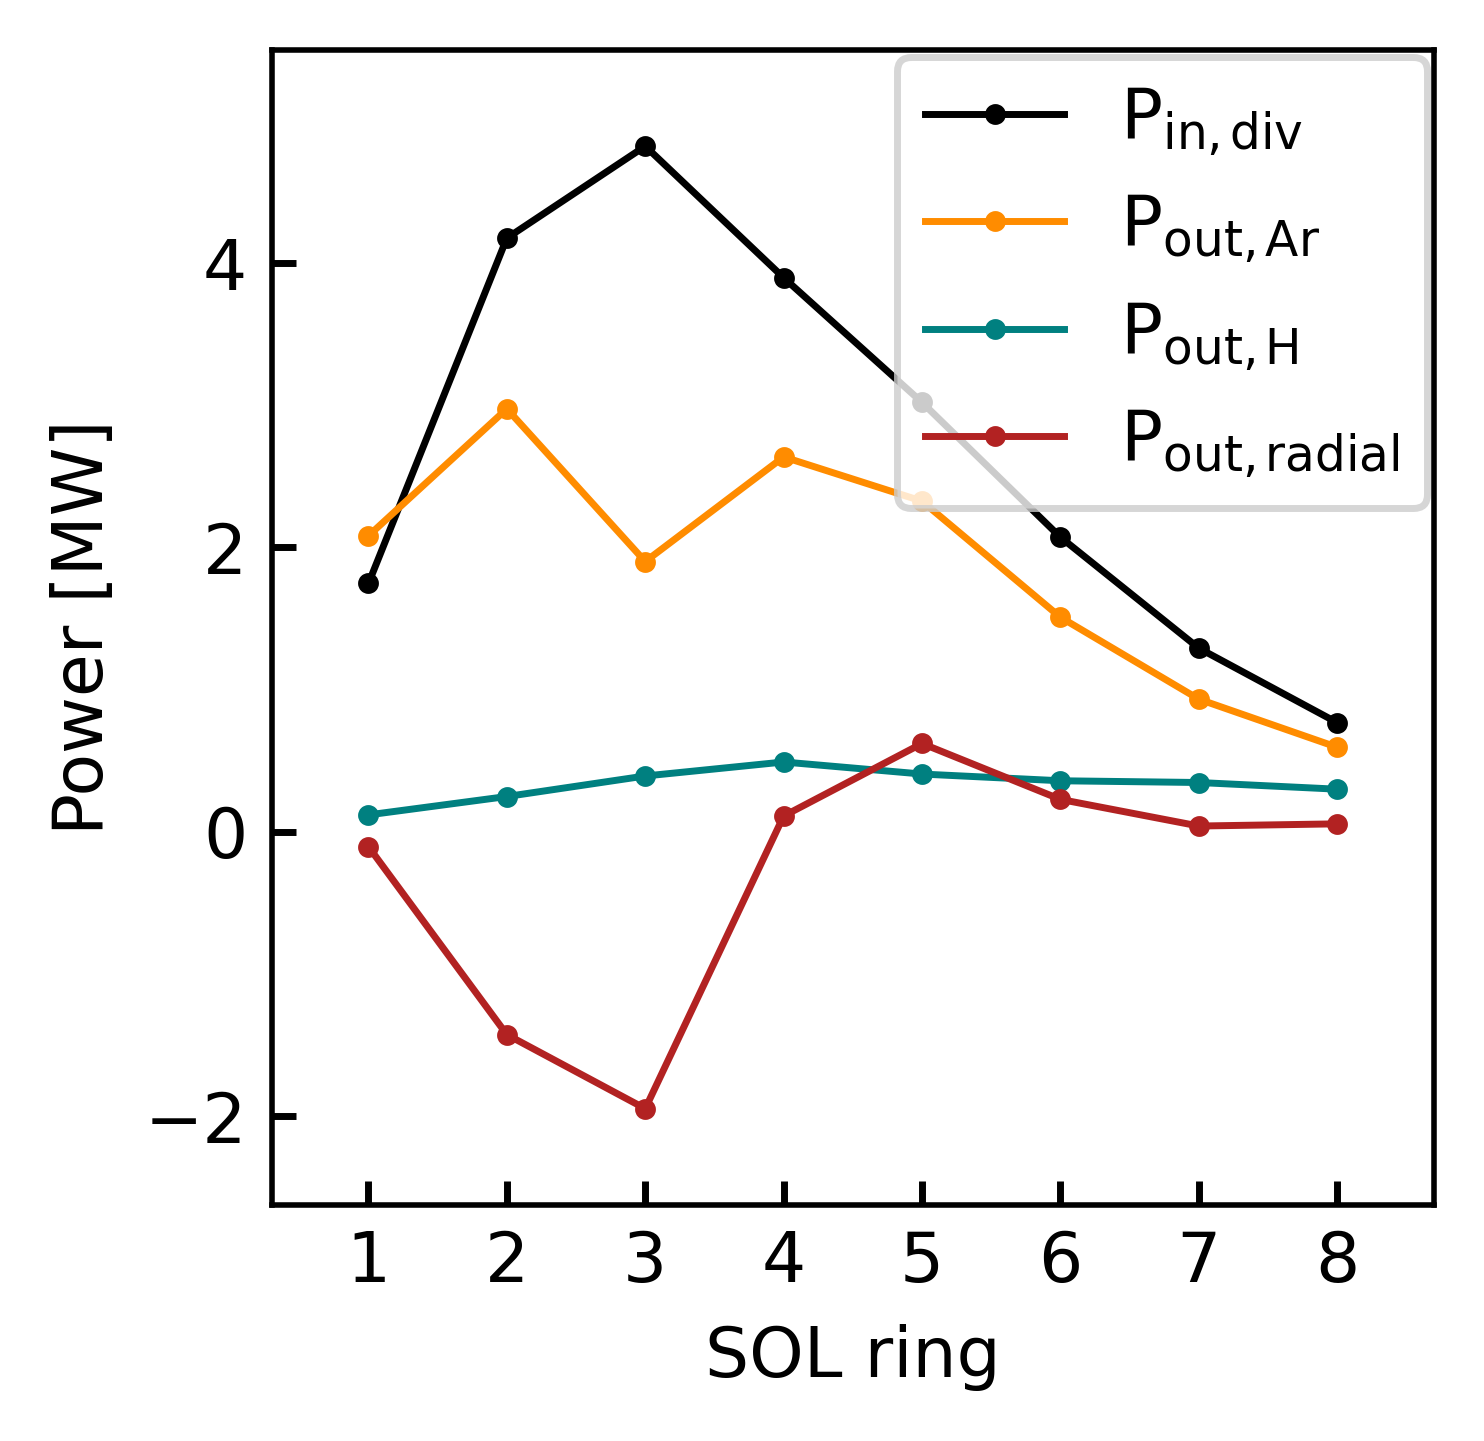

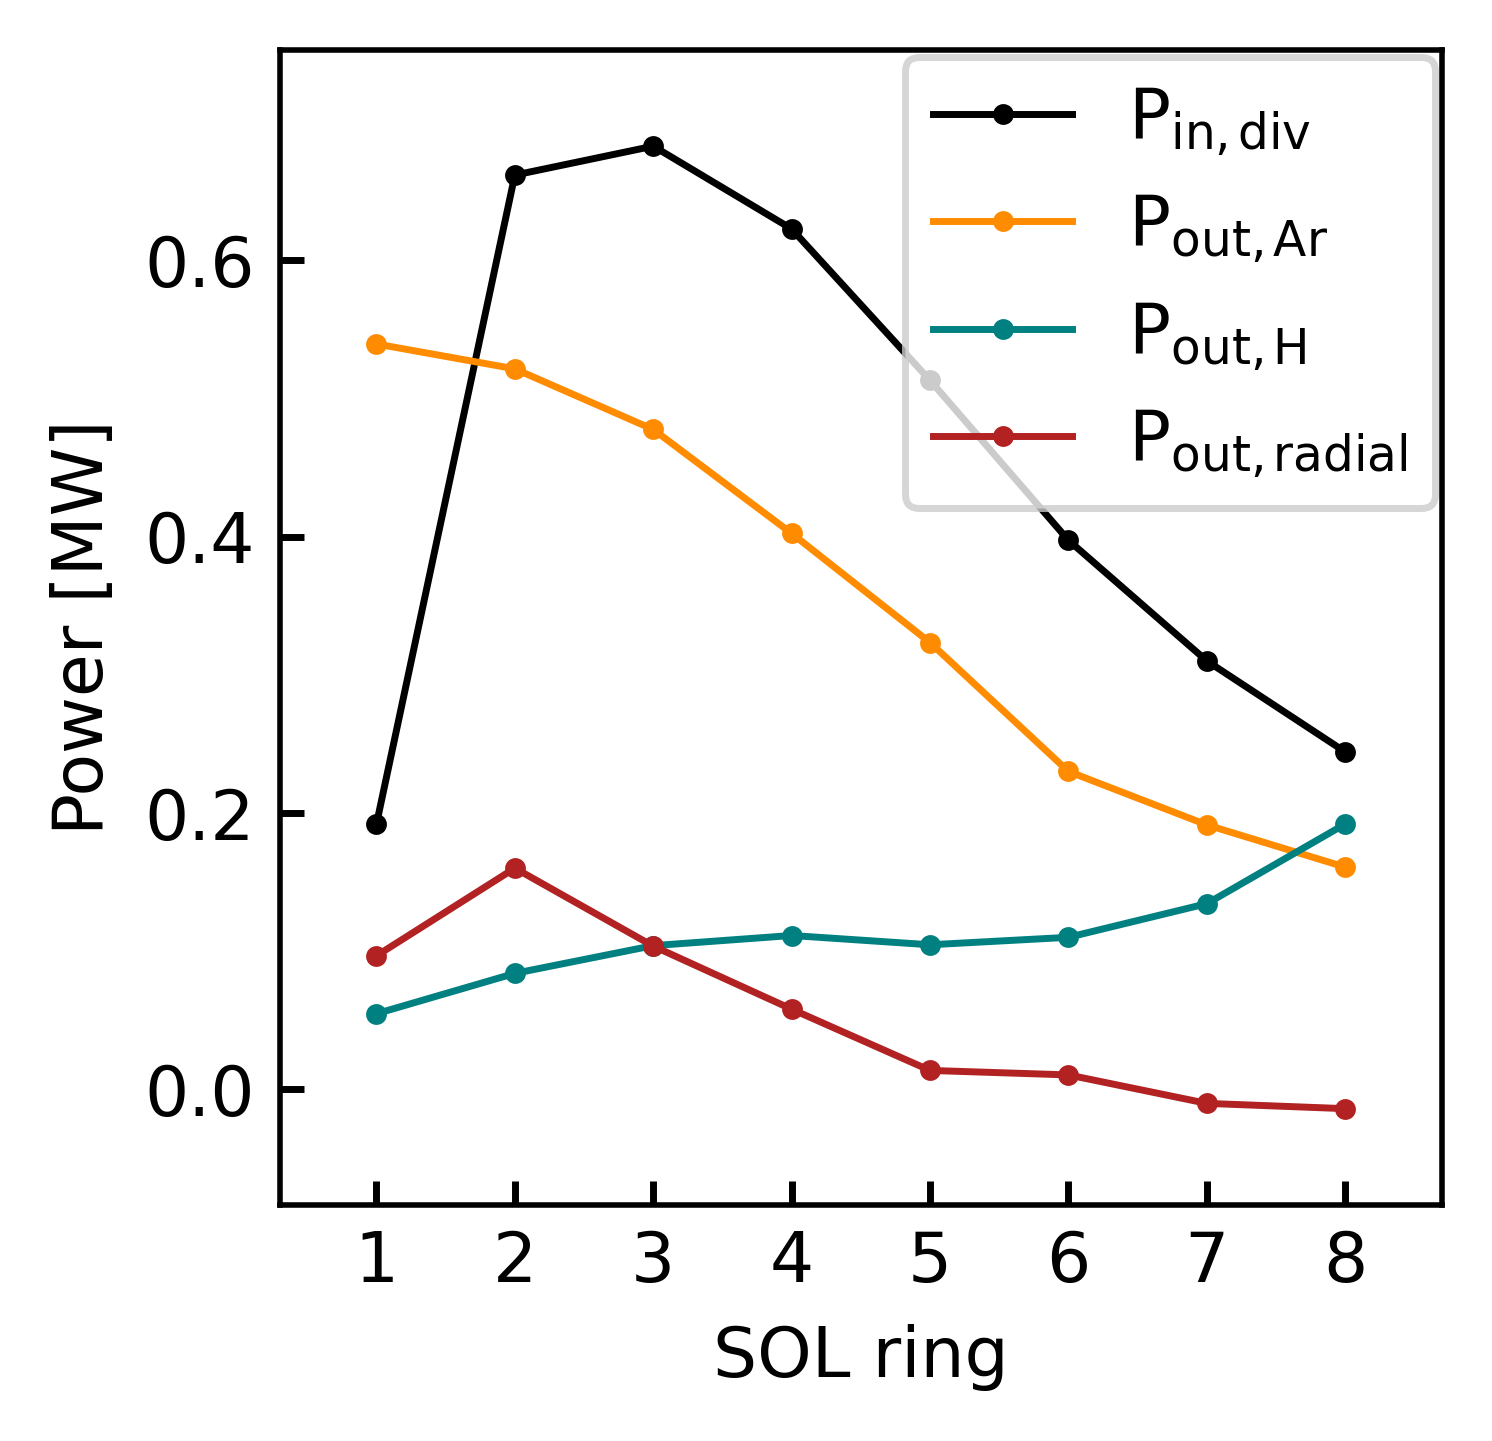

In [13]:
df = pd.DataFrame()

for region in ["outer_lower", "inner_lower"]:
    case = "100MW_innerar_midplanepuff"
    # case = "100MW_inner_arpuff"

    dfs = []
    for sepadd in range(8):
        baldict = store_slc[case].get_leg_energy_balance(
            sepadd = sepadd, region = region, impurities = ["Ar"], plot = False)
        df = pd.DataFrame.from_dict(baldict, orient = "index")
        df.columns = [sepadd+1]
        dfs.append(df)

    df = pd.concat(dfs, axis = 1).T
    df /= 1e6
    # df["Q_allsinks"] = df["Q_Ar"] + df["Q_H"] + df["Q_perp_out"]
    # df["P_radial"] = df["P_radial"].abs()
    fig, ax = plt.subplots(figsize = (3,3), dpi = 500)
    style = dict(marker = "o", ms = 2, lw = 1)
    ax.plot(df.index, abs(df["P_div"]), **style, c = "k",  label = r"$P_{in,div}$")
    ax.plot(df.index, df["P_Ar"], **style, c = "darkorange", label = r"$P_{out,Ar}$")
    ax.plot(df.index, df["P_H"], **style, c = "teal", label = r"$P_{out,H}$")
    ax.plot(df.index, df["P_radial"], **style, c = "firebrick", label = r"$P_{out,radial}$")

    # ax.plot(df.index, df["P_radial_e_bottom"], **style, c = "navy", label = r"$P_{out,radial,btm}$")
    # ax.plot(df.index, df["P_radial_e_top"], **style, c = "darkorange", label = r"$P_{out,radial,top}$")

    # df["P_allsinks"] = df["P_Ar"] + df["P_H"] + df["P_radial"]
    # ax.plot(df.index, df["P_allsinks"], c = "k", ls = ":", alpha = 0.5, label = "$P_{out,all}$")
    # ax2 = ax.twinx()
    # ax2.plot(df.index, df["qpar_mapped_to_target"], **style, ls = ":", c = "k", label = "$q_{\parallel,div}$")
    # ax2.set_ylabel("Heat flux [MW/$m^2$]")
    # ax2.grid(which = "both", visible = False)
    fig.legend(loc = "upper right", bbox_to_anchor = (0.9,0.88))
    ax.set_xlabel("SOL ring")
    ax.set_ylabel("Power [MW]")
    ax.grid(visible = True)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    # plt.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_SOLring_powerbalance_{region}.pdf", format = "pdf", bbox_inches = "tight")

## Particle balance

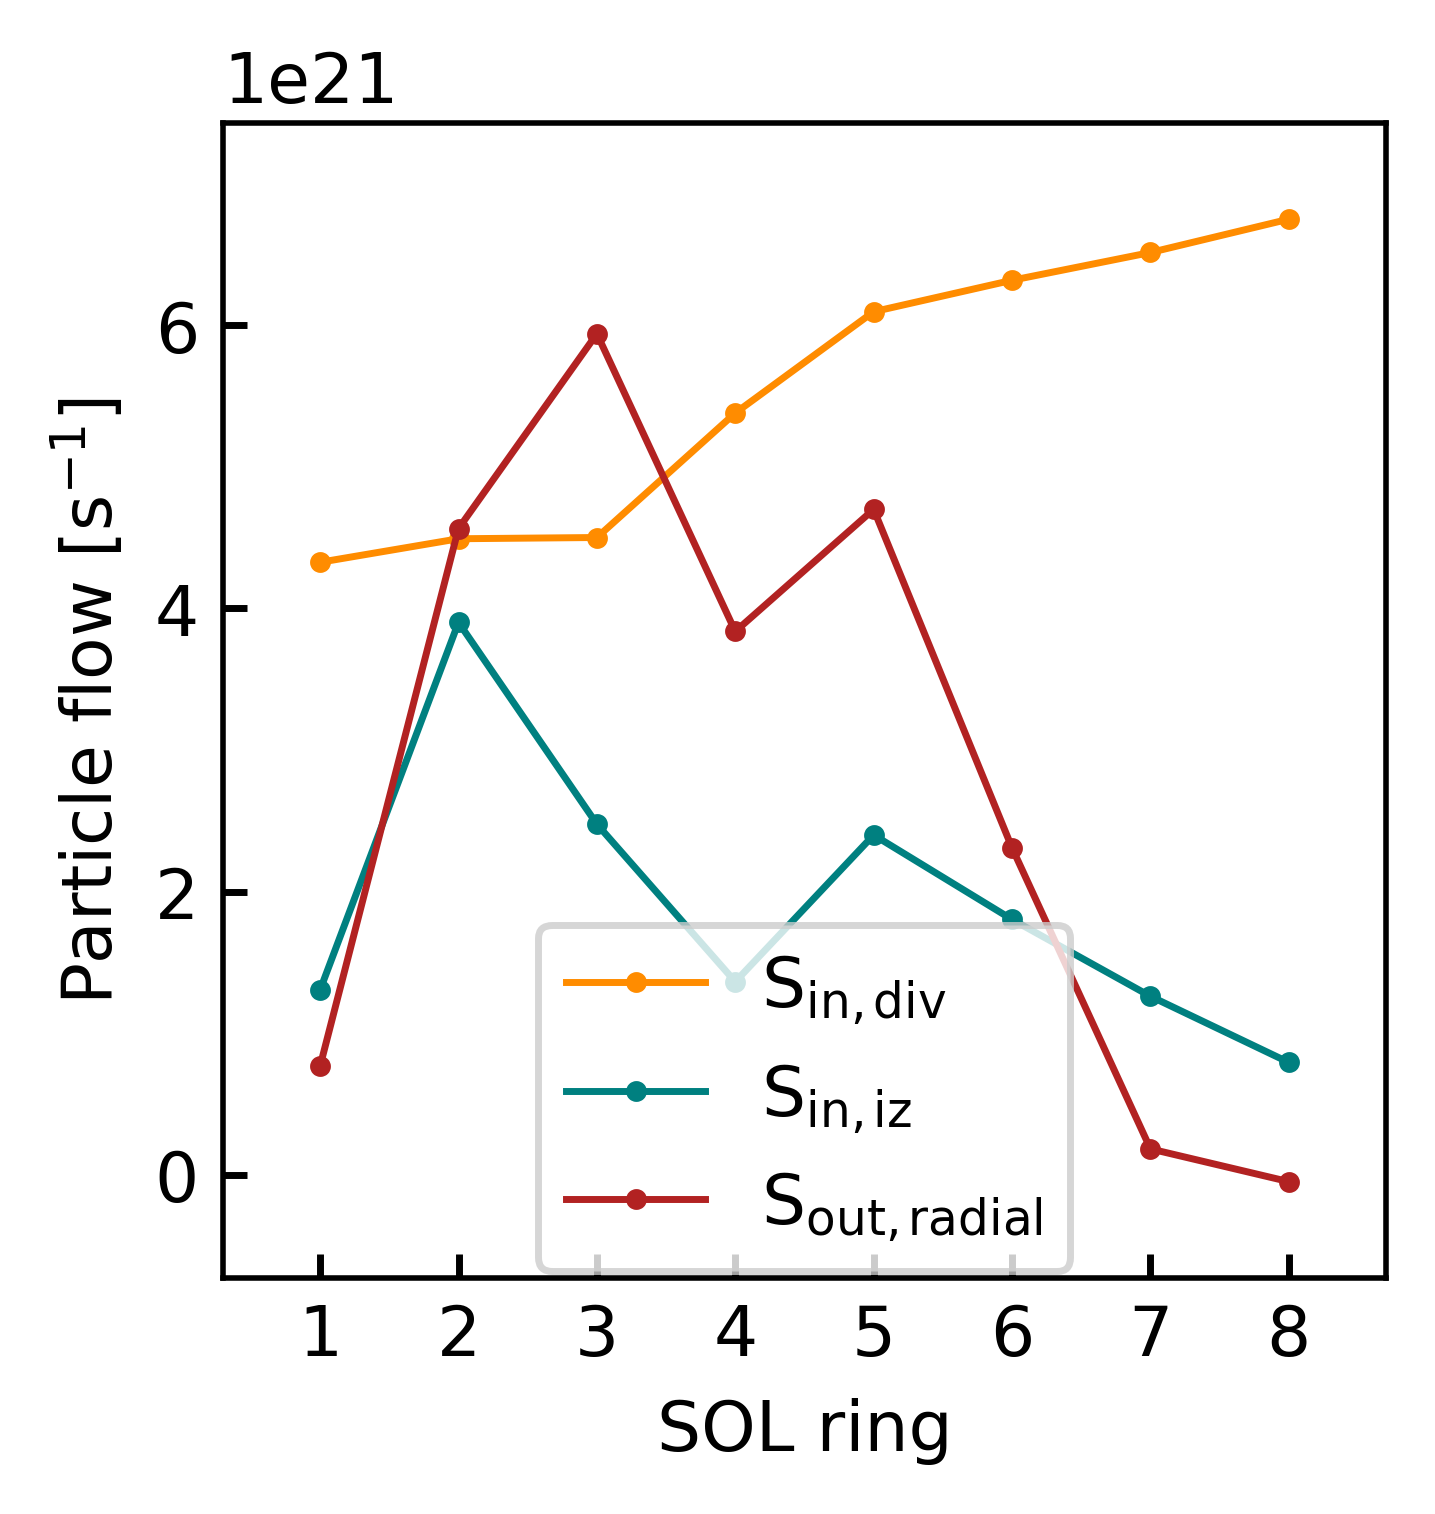

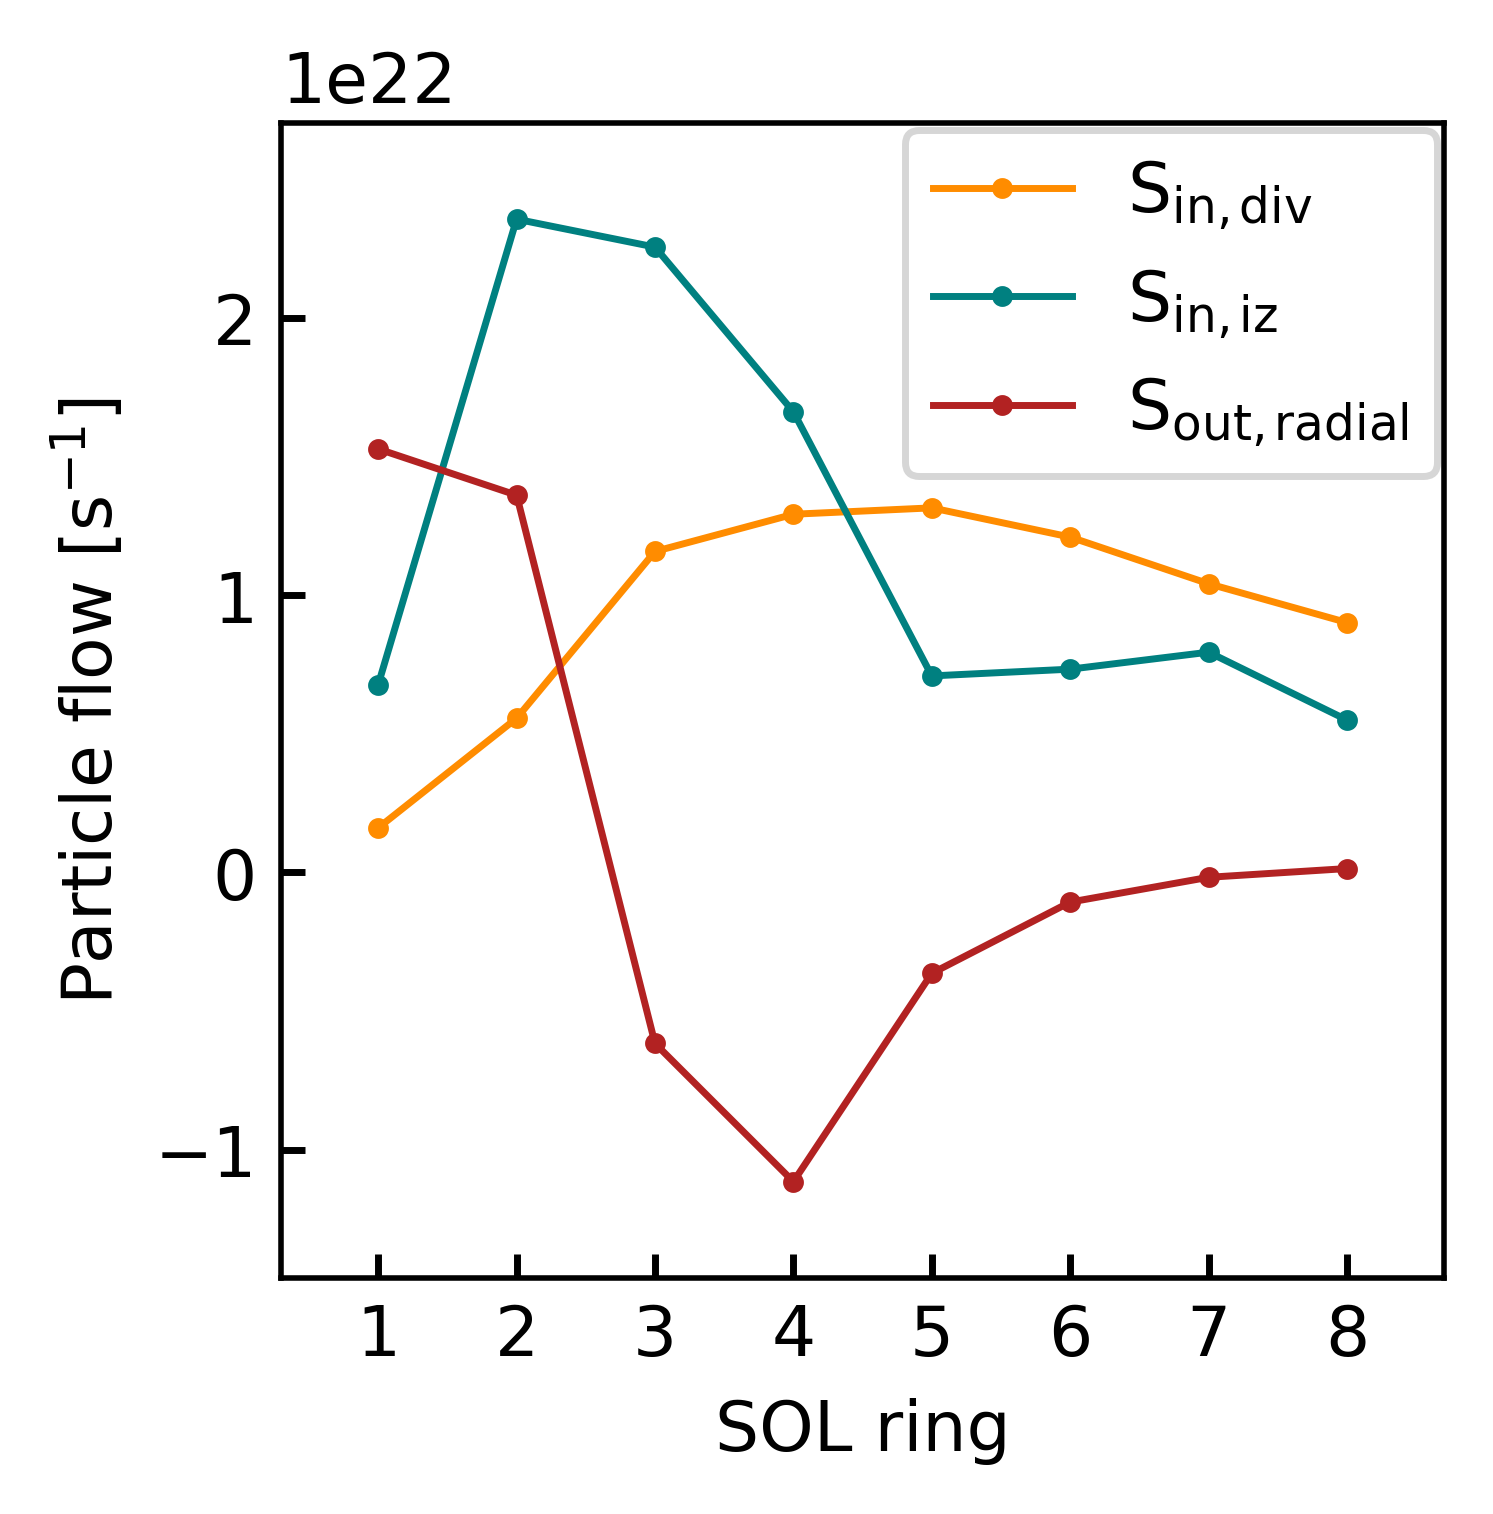

In [15]:
# for region in ["inner_lower", "outer_lower"]:
for region in ["inner_lower", "outer_lower"]:

    df = pd.DataFrame()
    # region = "outer_lower"
    case = "100MW_innerar_midplanepuff"

    dfs = []
    for sepadd in range(8):
        baldict = store_slc[case].get_leg_particle_balance(sepadd = sepadd, region = region, Te_threshold = 15)
        df = pd.DataFrame.from_dict(baldict, orient = "index")
        df.columns = [sepadd+1]
        dfs.append(df)

    df = pd.concat(dfs, axis = 1).T

    fig, ax = plt.subplots(figsize = (3,3), dpi = 500)
    style = dict(marker = "o", ms = 2, lw = 1)
    ax.plot(df.index, df["S_div"], **style, c = "darkorange",  label = r"$S_{in,div}$")
    ax.plot(df.index, df["S_iz"], **style, c = "teal", label = r"$S_{in,iz}$")
    ax.plot(df.index, df["S_radial"], **style, c = "firebrick", label = r"$S_{out,radial}$")
    # ax.set_yscale("symlog")
    ax.legend()
    ax.grid(visible = True)
    ax.set_xlabel("SOL ring")
    ax.set_ylabel("Particle flow [$s^{-1}$]")
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    # plt.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_SOLring_particlebalance_{region}.pdf", format = "pdf", bbox_inches = "tight")

## Peak heat flux

In [48]:
store_slc.keys()

dict_keys(['100MW_inner_arpuff', '100MW_innerar_midplanepuff'])

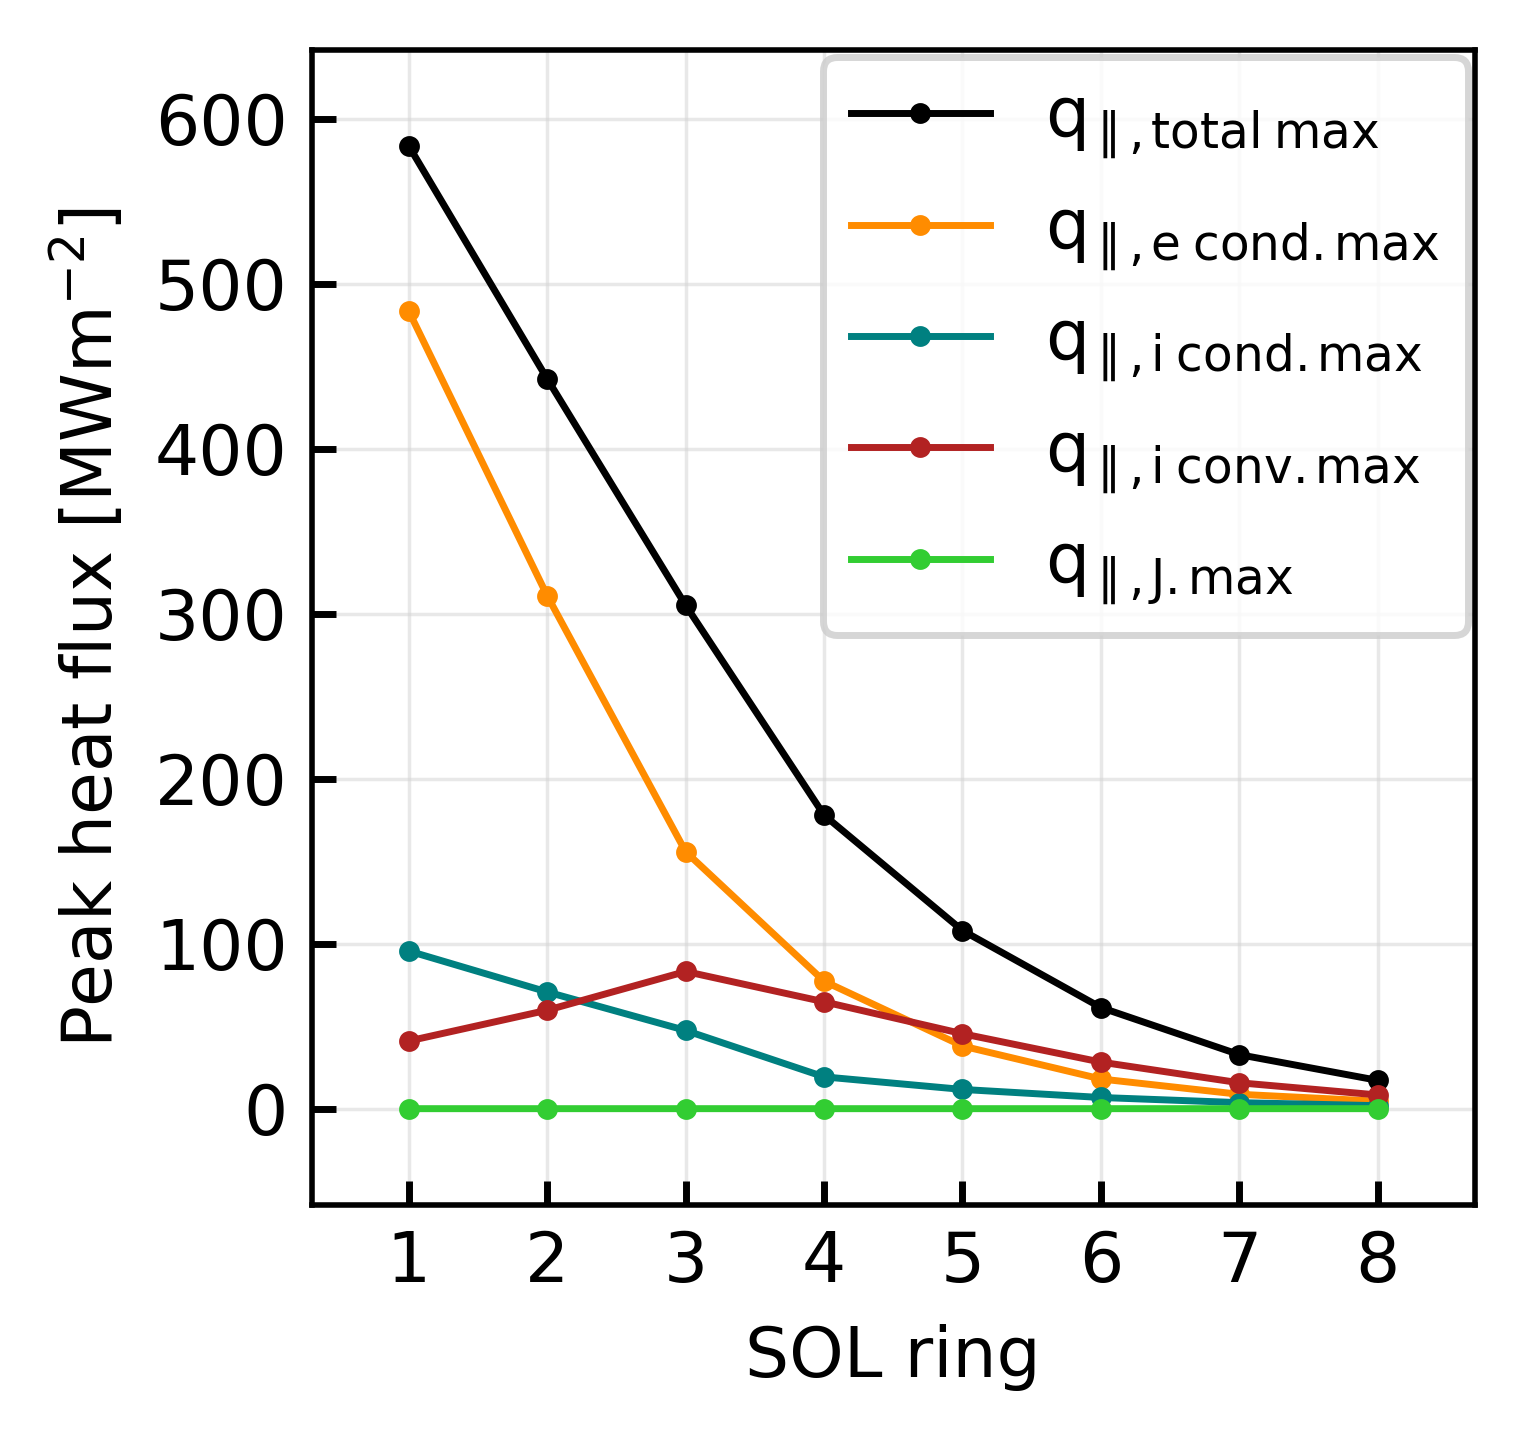

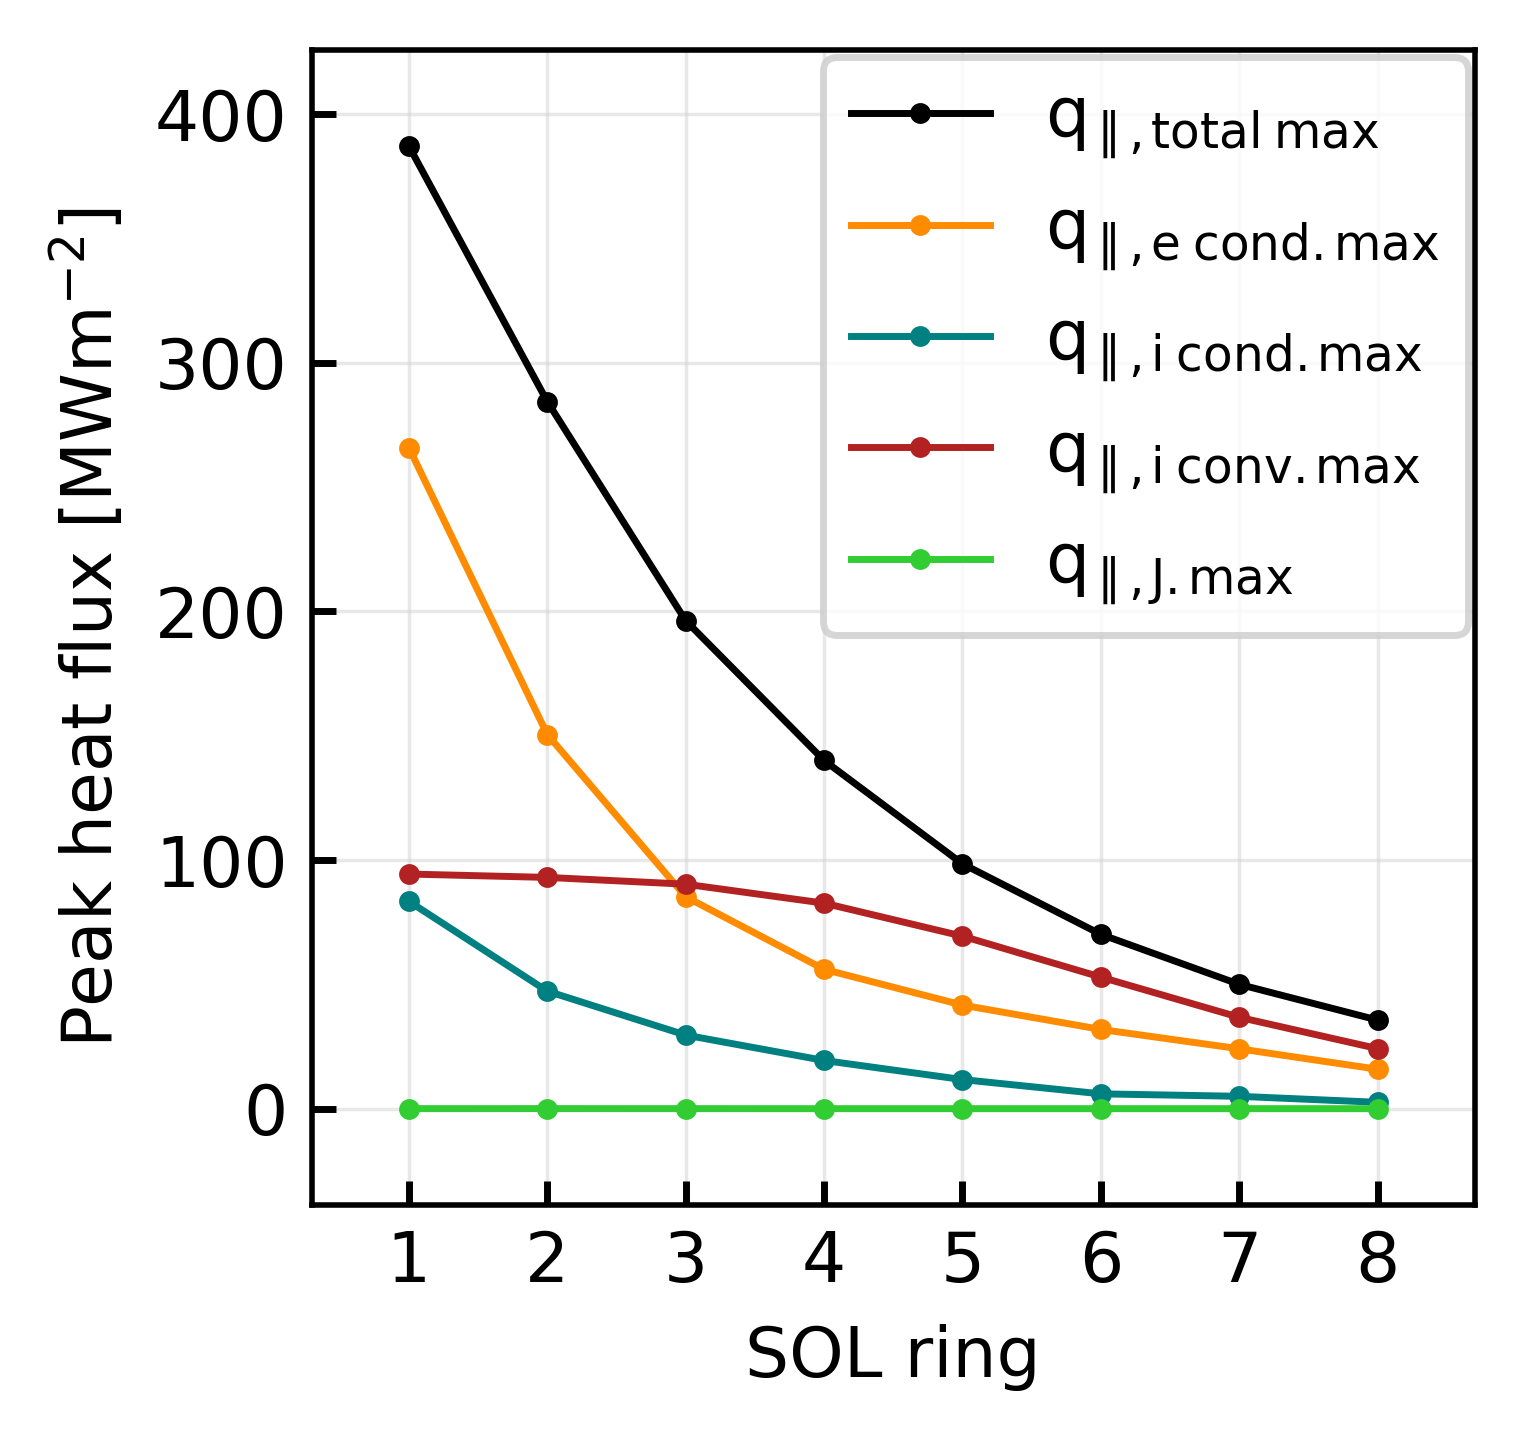

In [17]:
sepadd = 0
# region = "outer_lower"
# region = "inner_lower"
# case = '100MW_inner_arpuff'
case = '100MW_innerar_midplanepuff'

for region in ["outer_lower", "inner_lower"]:
    df = pd.DataFrame()
    slc = store_slc[case]
    for sepadd in range(8):
        fline = slc.get_1d_poloidal_data(["Te", "RAr", "ne", "fhex_cond", "fhex_32", "fhix_cond", "fhix_32", "fhex_thermj", "fhx_total"], sepadd = sepadd, region = region, target_first = True)
        
        for param in ["fhex_32", "fhix_32"]:
            fline[param] = fline[param] * 5/3

        mult = -1 if "inner_lower" in region else 1
        
        for param in fline.columns:
            if param.startswith("fh"):
                fline[param] = fline[param] / fline["apar"]
                fline[param] *= mult
        solring = sepadd + 1
        df.loc[solring, "e_cond"] = fline["fhex_cond"].max()
        df.loc[solring, "i_cond"] = fline["fhix_cond"].max()
        df.loc[solring, "i_conv"] = fline["fhix_32"].max()
        df.loc[solring, "e_curr"] = fline["fhex_thermj"].max()
        df.loc[solring, "total"] = fline["fhx_total"].max()
        
        if fline["fhx_total"].mean() < 0:
            raise Exception("Total heat flux negative, fix sign")



    df /= 1e6
    # display(df)
    fig, ax = plt.subplots(figsize = (3,3), dpi = 500)
    style = dict(marker = "o", ms = 2, lw = 1)
    ax.plot(df.index, df["total"], **style, c = "k",  label = r"$q_{\parallel,total\ max}$")
    ax.plot(df.index, df["e_cond"], **style, c = "darkorange",  label = r"$q_{\parallel,e\ cond. max}$")
    ax.plot(df.index, df["i_cond"], **style, c = "teal", label = r"$q_{\parallel,i\ cond. max}$")
    ax.plot(df.index, df["i_conv"], **style, c = "firebrick", label = r"$q_{\parallel,i\ conv. max}$")
    ax.plot(df.index, df["e_curr"], **style, c = "limegreen", label = r"$q_{\parallel,J. max}$")

    ax.legend(fontsize = "medium")
    ax.set_xlabel("SOL ring")
    ax.set_ylabel("Peak heat flux [$MWm^{-2}$]")
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.grid(visible = True)
    # plt.savefig(rf"C:\Users\Mike\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_SOLring_heatfluxes_{region}.pdf", format = "pdf", bbox_inches = "tight")

# Run outer target


## Setup


In [18]:
comps_outer = {}
num_sepadds = 5

In [85]:
study = "ring3"
cvar = "impurity_frac"
region = "outer_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_outer[study] = {}

hflux_corrections = [1.10, 1.11, 1.12, 1.26, 0.98]
i = 3  # Sepadd

test = run_DLS(
    {"cooling_curve" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
    "kappa0" : 2500
    }, 
    store_slc[case],  
    cvar, region, i, hflux_corr = hflux_corrections[0],
    return_comp = False) 

Solving...0.27...Complete in 2.6 seconds


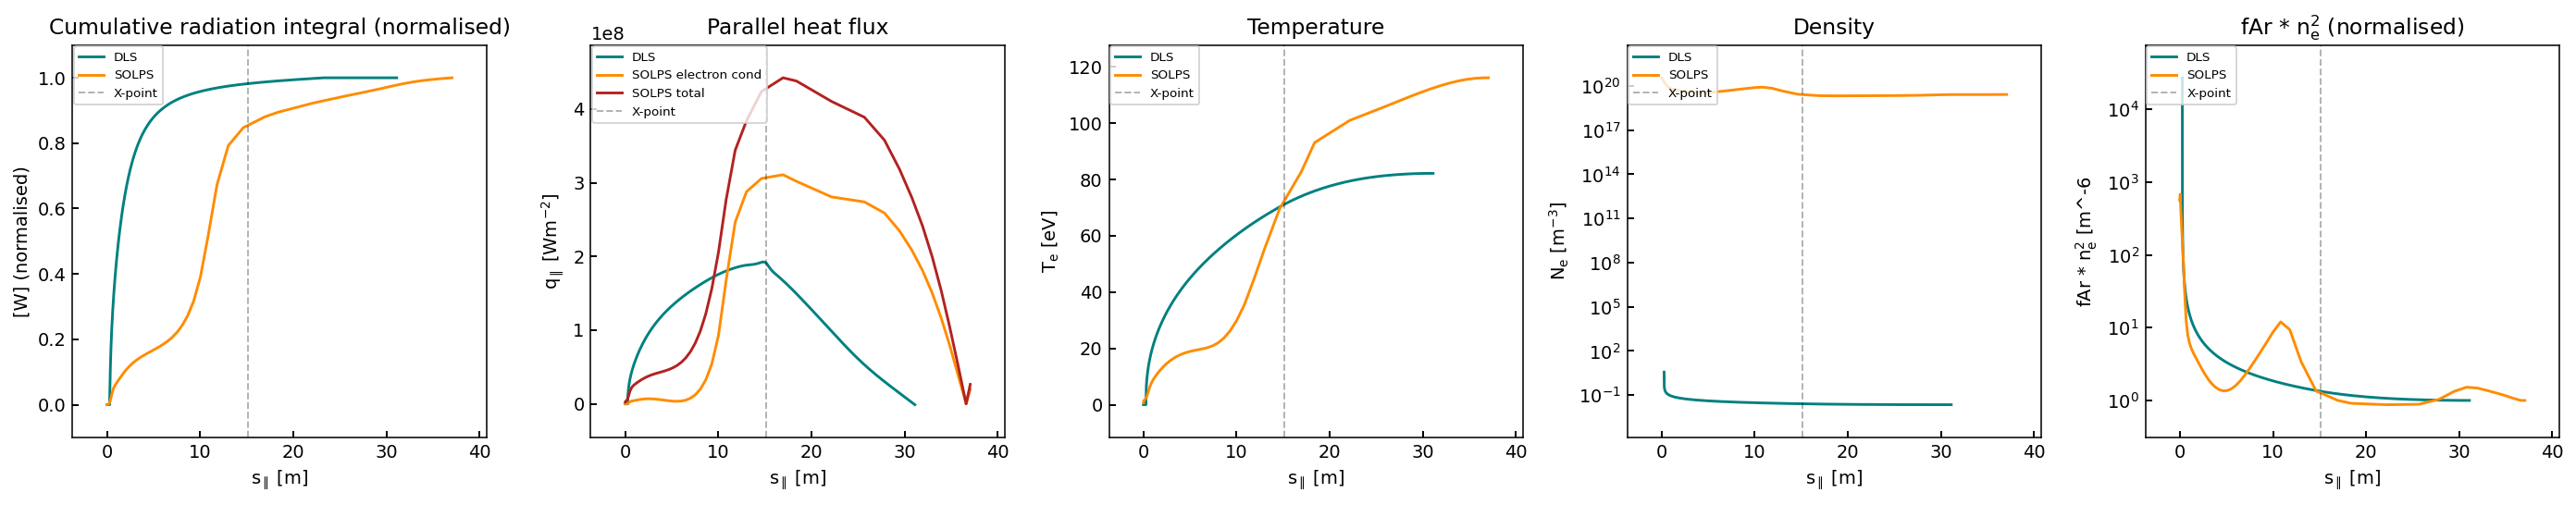

In [92]:
comp = compare_SOLPS_DLS(
            slc, test, cvar, impurity="Ar", region=region, sepadd=sepadd
        )
comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

In [84]:
def run_DLS(custom_inputs, slc, cvar, region, sepadd, hflux_corr=1, return_comp = True):
    ## Get SOLPS field line and max qpar
    df = slc.get_1d_poloidal_data(
        params=["fhx_total", "Ne"], sepadd=sepadd, region=region, target_first=True
    )
    qpar_max = (df["fhx_total"] / df["apar"]).abs().max()

    ## Input deck
    inputs = SimulationInputs(
        control_variable=cvar,
        SparRange=[
            slc.extract_front_pos(
                sepadd=sepadd,
                region=region,
                impurity="Ar",
                method="qpar_tot",
                threshold=0.05,
            )
        ],
        qpllu0=qpar_max * hflux_corr,
        nu0=df["Ne"].iloc[-1],
        cz0=0.05,
        cooling_curve=slc.extract_cooling_curve("Ar", region, sepadd=i, plot=False),
        kappa0=slc.extract_kappa0(sepadd=sepadd, region=region),
        grid_refinement_ratio=10,
        grid_refinement_width=1,
        grid_resolution=1000,
    )

    try:
        out = run_dls(
            dataclasses.replace(inputs, **custom_inputs),
            MagneticGeometry.from_profile(eqb_alt[case][region][sepadd]),
        )
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    if return_comp:
        return compare_SOLPS_DLS(
            slc, out, cvar, impurity="Ar", region=region, sepadd=sepadd
        )
    else:
        return out


def get_correction_factors(comp):
    fhx_solps = comp.solps[comp.solps["Xpoint"] == 1]["fhx_total"].abs().values[0]
    fhx_dls = comp.dls[comp.dls["Xpoint"] == 1]["qpar"].values[0]
    hflux_factor = fhx_solps / fhx_dls

    kappa_factor = (comp.dls["Te"].max() / comp.solps["Te"].max()) ** 2

    return hflux_factor, kappa_factor

## Run selected SOL rings
- With and without fitted curve

In [67]:
comps_outer = {}

### Without fitted curve

Solving...0.68...Complete in 2.8 seconds
    Hflux factor for sepadd 1: 1.09
Solving...0.38...Complete in 2.4 seconds
    Hflux factor for sepadd 2: 1.09
Solving...0.37...Complete in 2.7 seconds
    Hflux factor for sepadd 4: 1.12


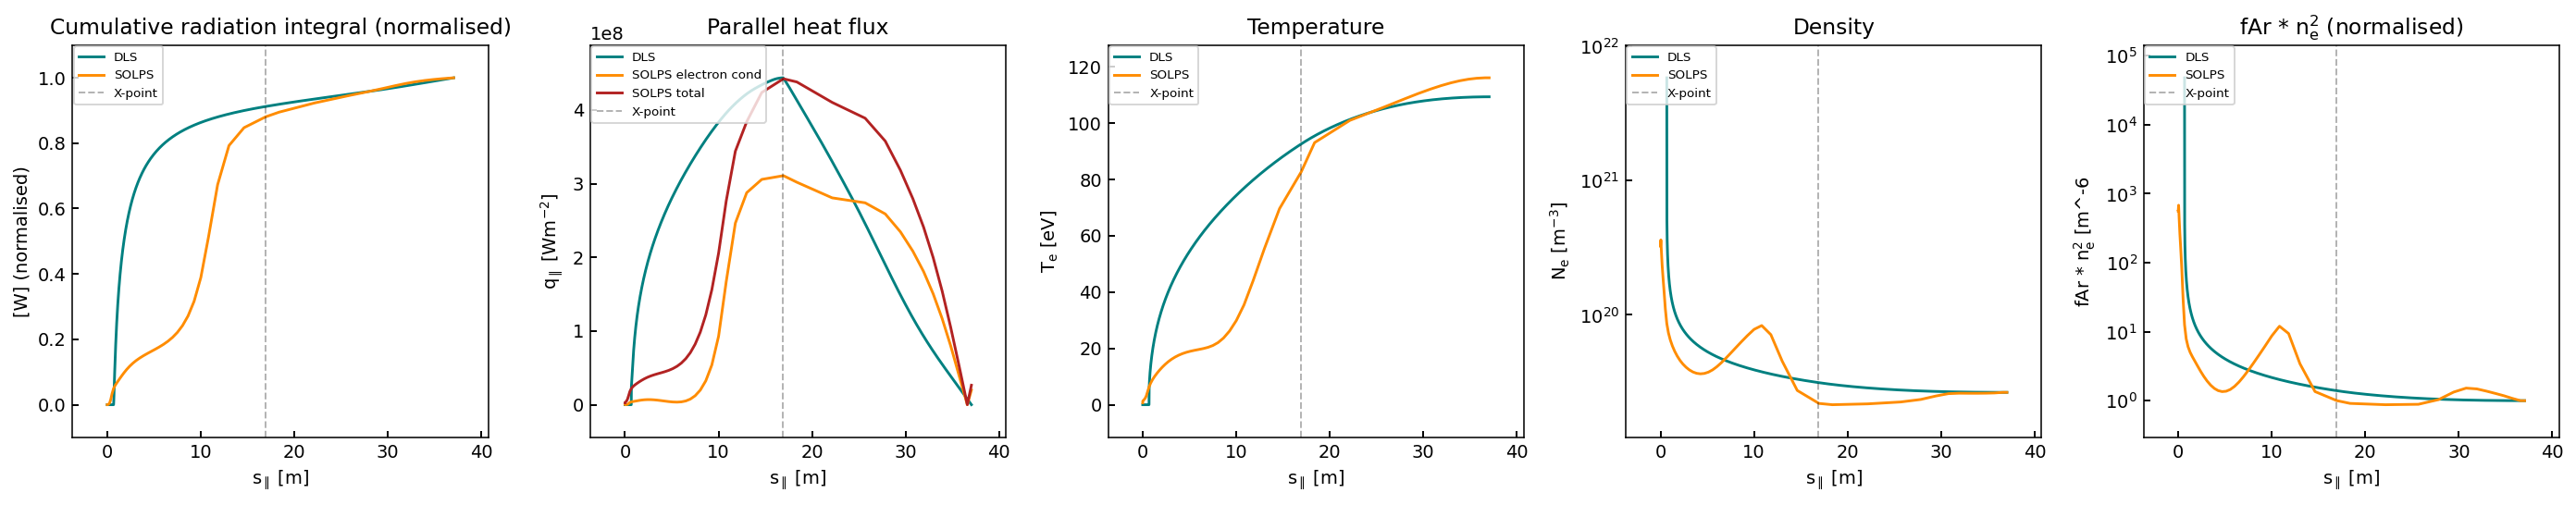

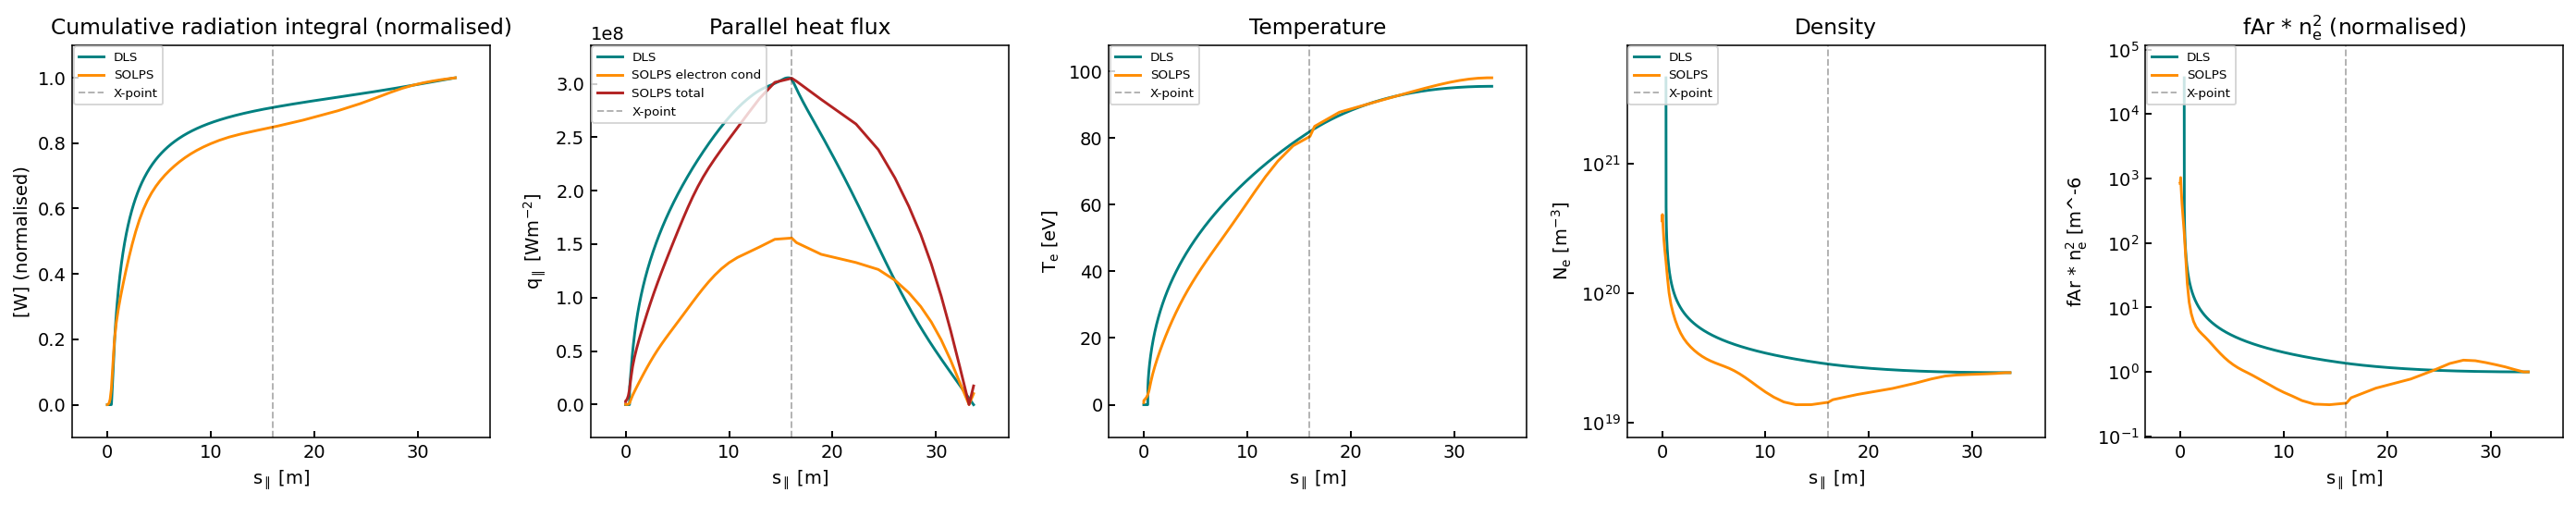

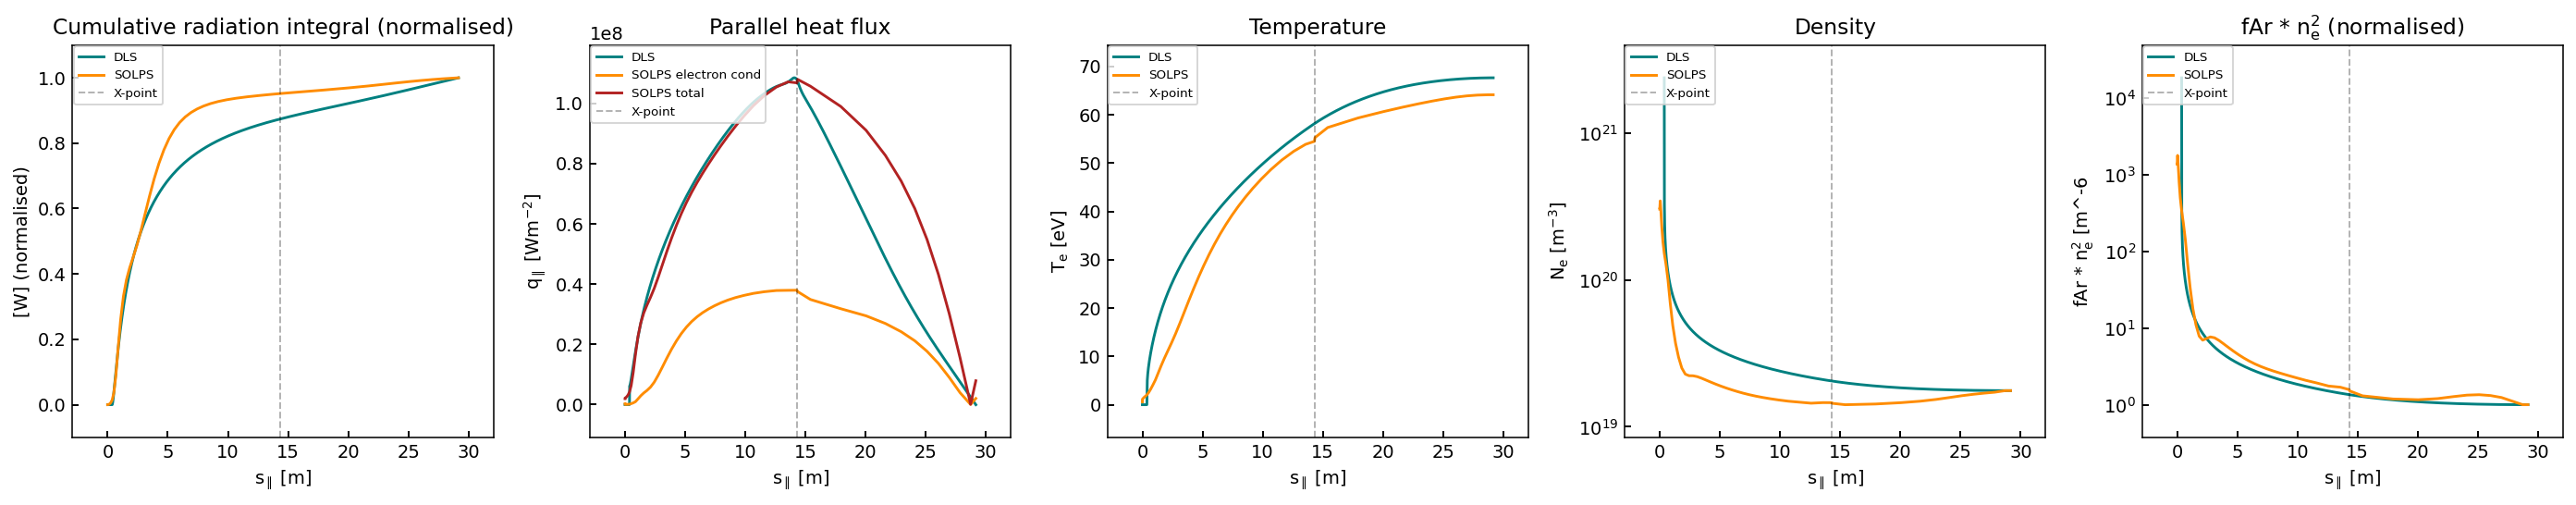

In [96]:
study = "adas_curve"
cvar = "impurity_frac"
region = "outer_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_outer[study] = {}

hflux_corrections = {0: 1.40, 1: 1.09, 2: 1.09, 3: 1.03, 4: 1.13}

for i in [1,2,4]:
    input = {
        "cooling_curve" : curves["Ar"][1e16],
        "kappa0" : 2500
    }

    comps_outer[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_outer[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)
    
    hflux_factor, kappa_factor = get_correction_factors(comps_outer[study][i])
    print(f"    Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### With fitted curve

Solving...0.68...Complete in 3.5 seconds
    Hflux factor for sepadd 1: 1.10
Solving...0.38...Complete in 3.4 seconds
    Hflux factor for sepadd 2: 1.08
Solving...0.37...Complete in 3.2 seconds
    Hflux factor for sepadd 4: 1.00


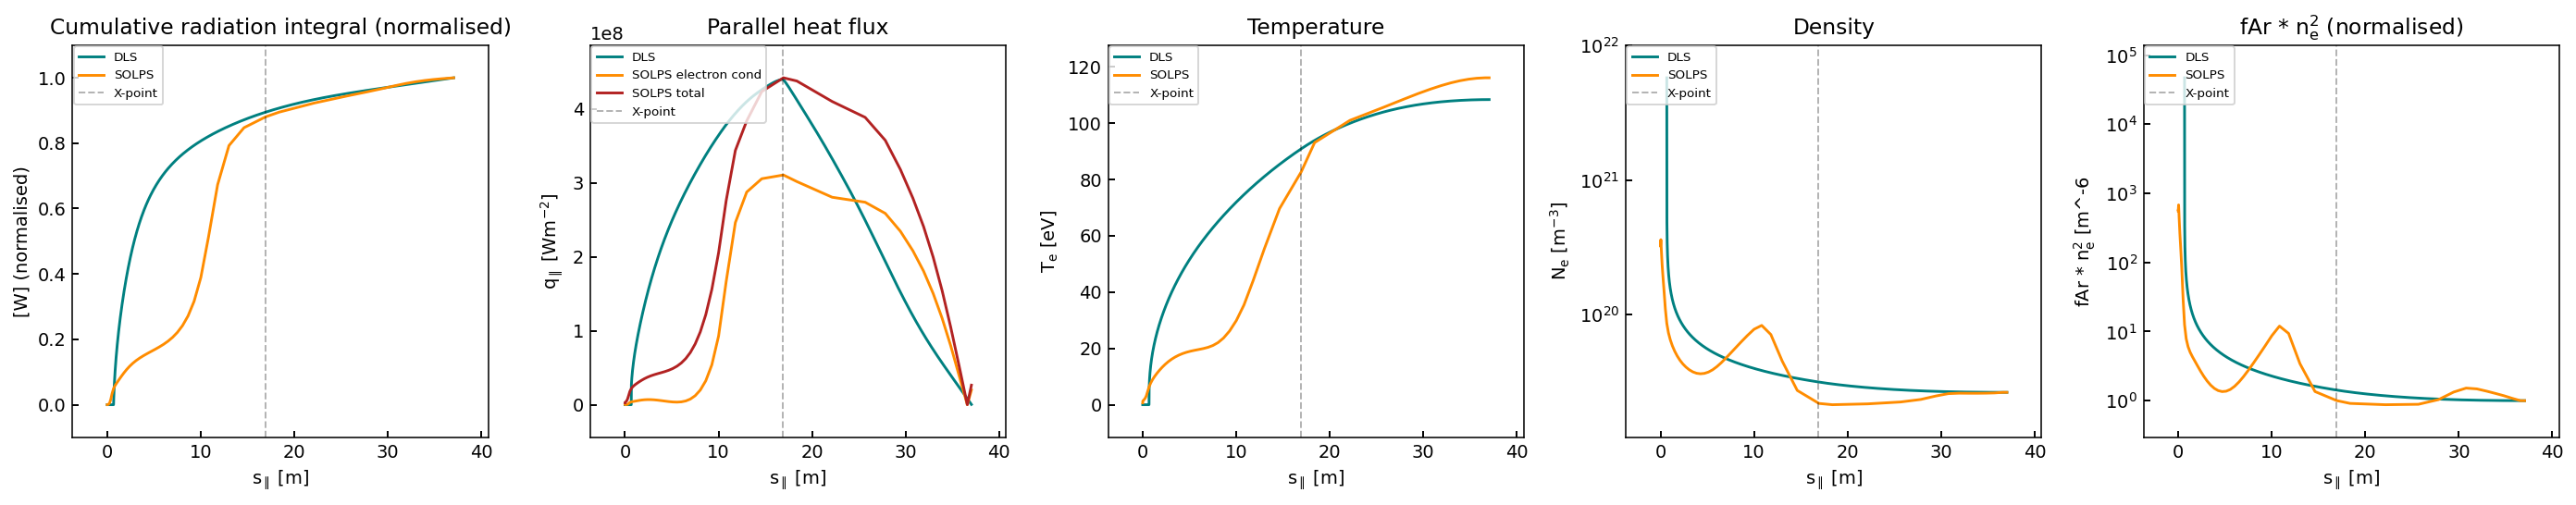

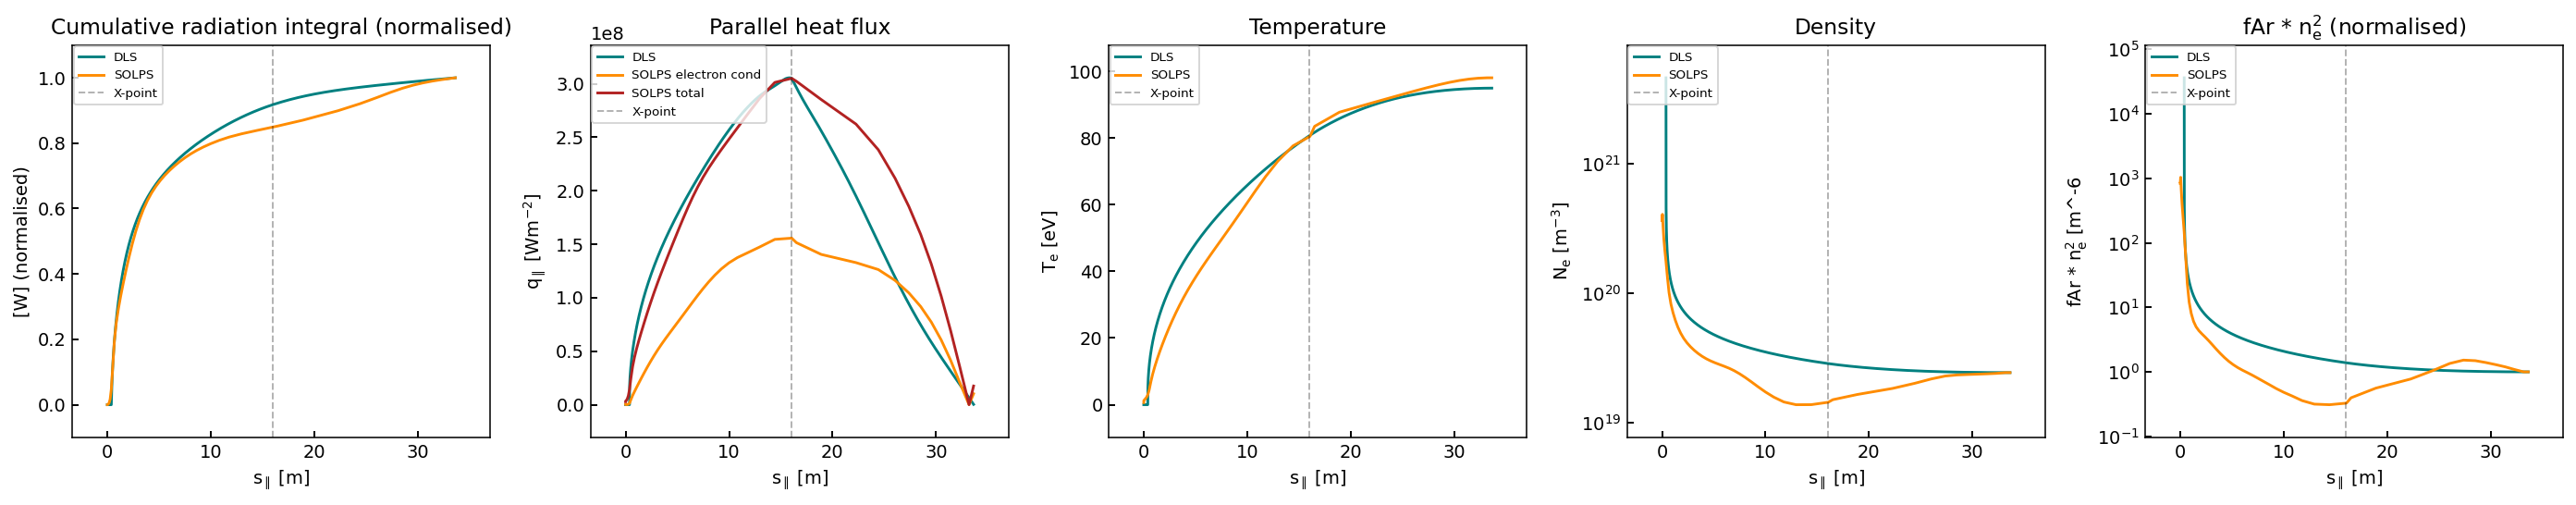

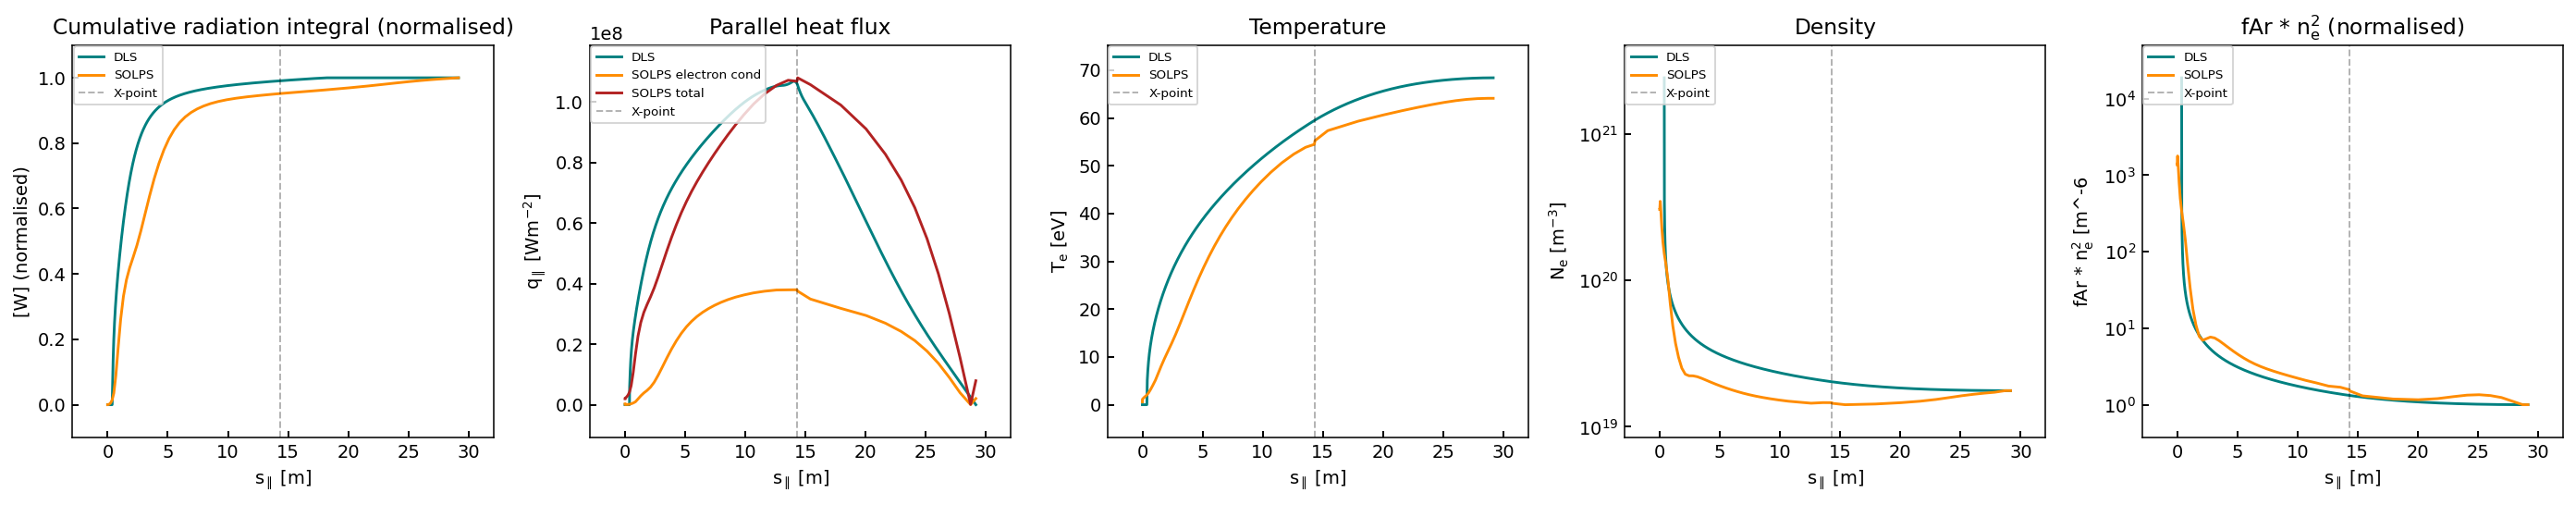

In [70]:
study = "fit_curve"
cvar = "impurity_frac"
region = "outer_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_outer[study] = {}

hflux_corrections = {0: 1.40, 1: 1.10, 2: 1.08, 3: 1.00, 4: 0.99}

for i in [1,2,4]:
    input = {
        "cooling_curve" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "kappa0" : 2500
    }

    comps_outer[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_outer[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)
    
    hflux_factor, kappa_factor = get_correction_factors(comps_outer[study][i])
    print(f"    Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### Fit curve, fit kappa

Solving...0.68...Complete in 3.4 seconds
  Hflux factor for sepadd 1: 1.03
  Kappa factor for sepadd 1: 0.75
Solving...0.38...Complete in 4.1 seconds
  Hflux factor for sepadd 2: 1.06
  Kappa factor for sepadd 2: 0.90
Solving...0.37...Complete in 1.1 seconds
  Hflux factor for sepadd 4: 1.02
  Kappa factor for sepadd 4: 1.26


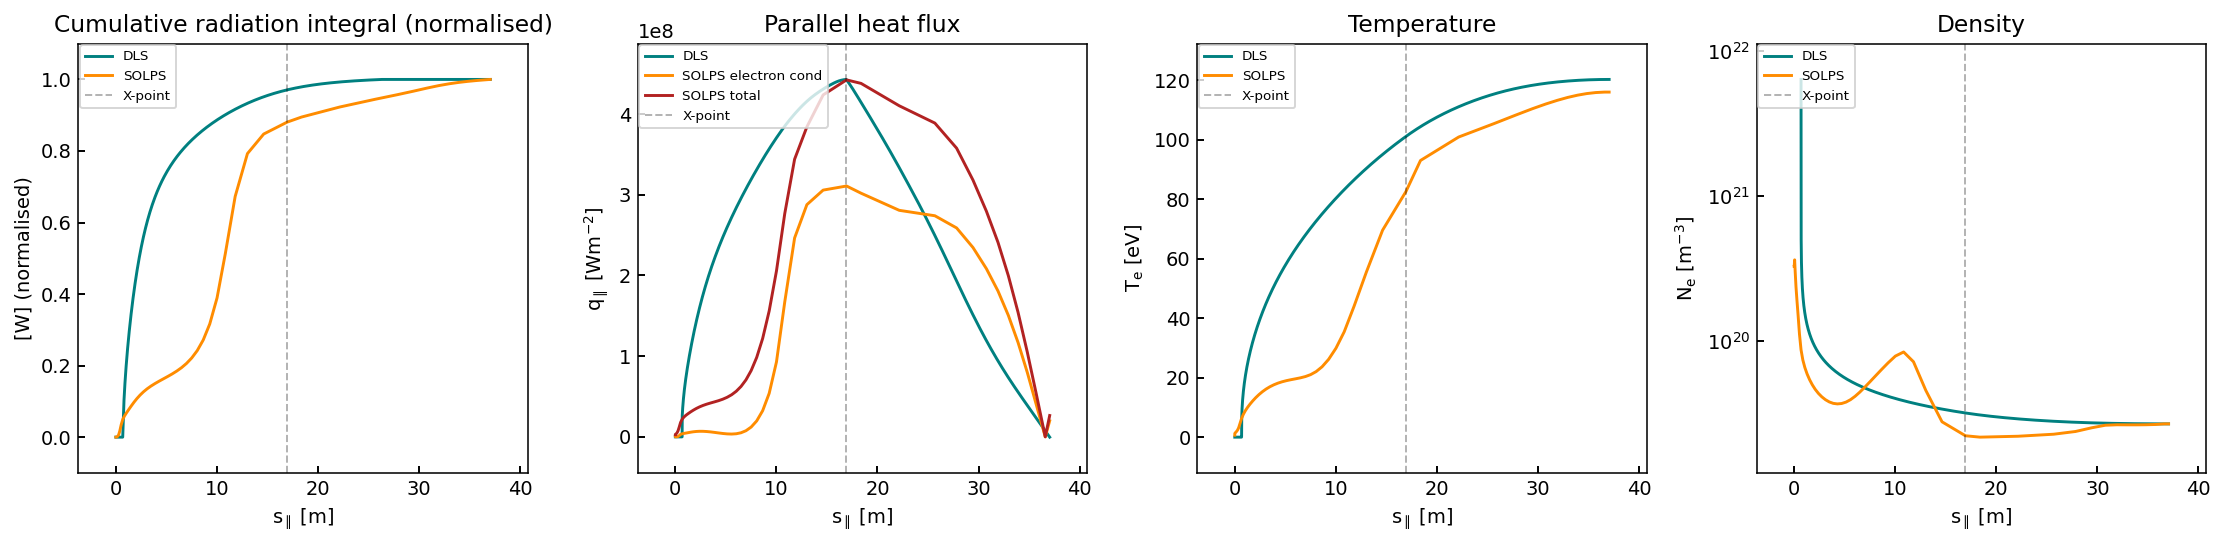

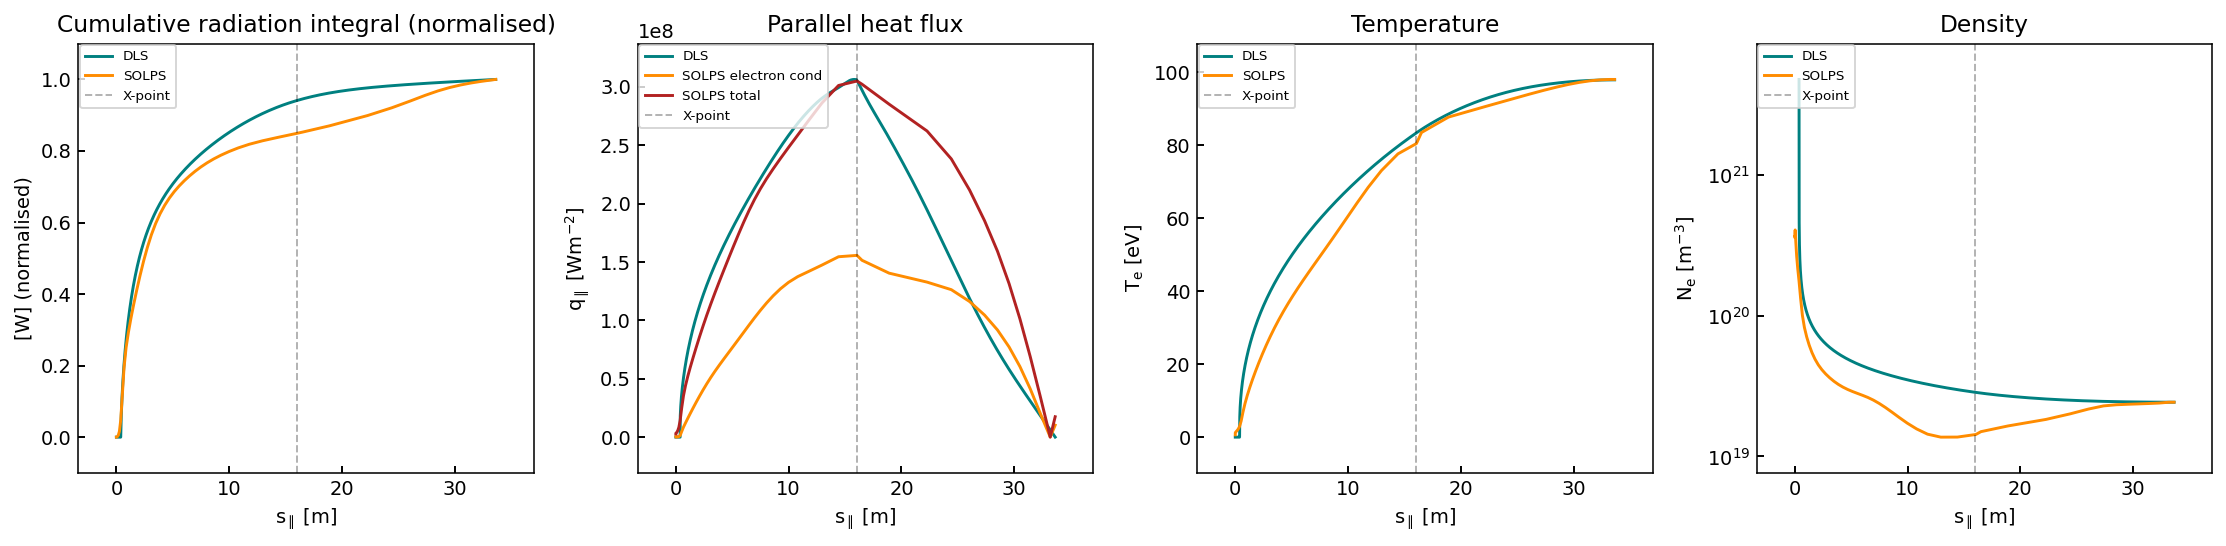

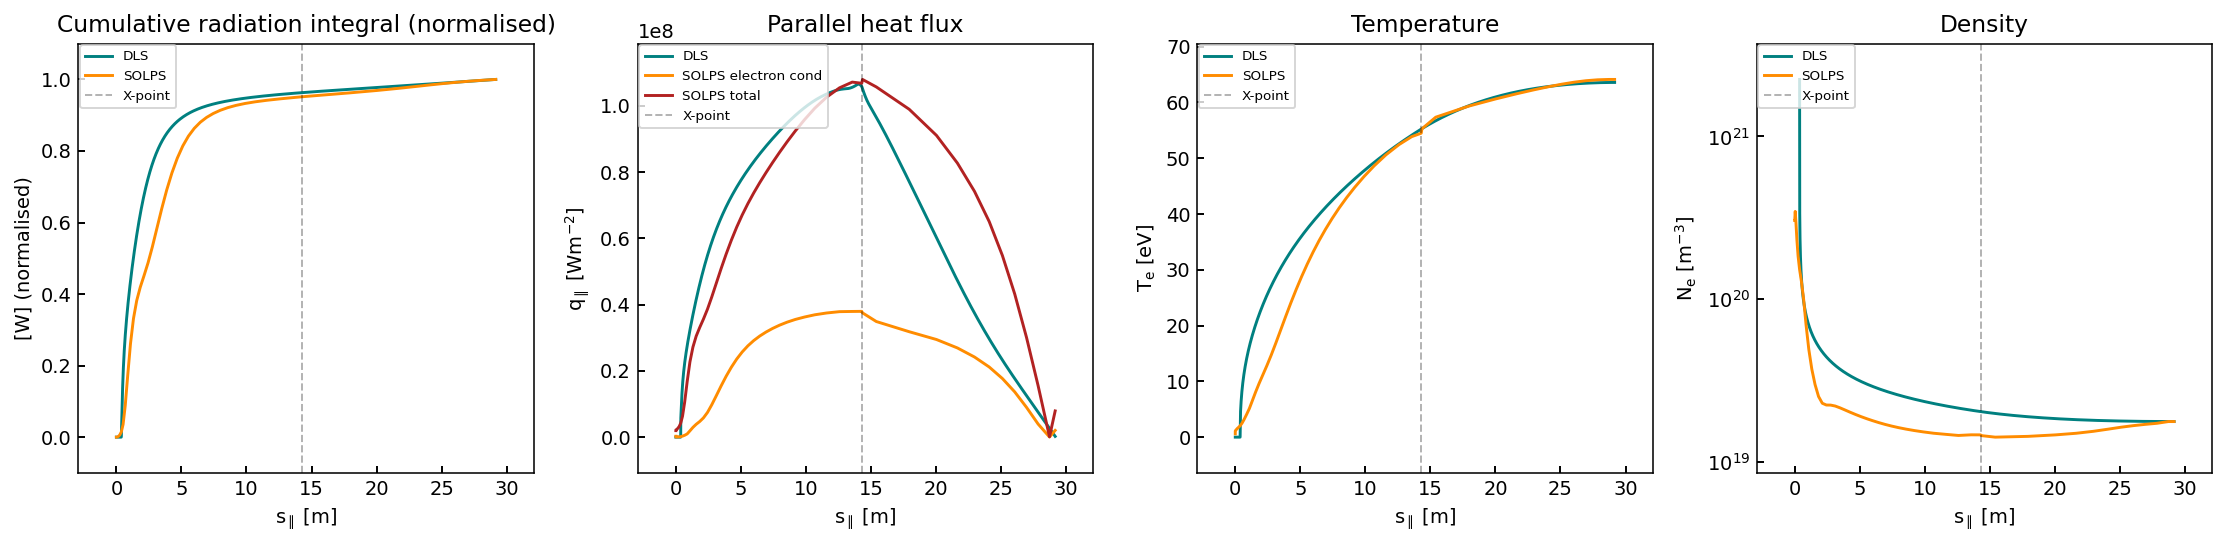

In [71]:
study = "fit_curve_kappa"
cvar = "impurity_frac"
region = "outer_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_outer[study] = {}

hflux_corrections = [1.03, 1.06, 1.01]
kappa_corrections = [0.70, 0.90, 1.28]

for idx, i in enumerate([1,2,4]):
    input = {
        "cooling_curve" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        # "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region, total_hflux = True, skip_xpoint = False, print_kappa = True),
        "kappa0" : 2500 * kappa_corrections[idx]
    }

    comps_outer[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[idx])  
    comps_outer[study][i].plot(["Cumrad", "qpar", "Te", "Ne"], normalise_radiation = True, radiation_per_area = False)
    
    hflux_factor, kappa_factor = get_correction_factors(comps_outer[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[idx]:.2f}")
    print(f"  Kappa factor for sepadd {i}: {kappa_factor * kappa_corrections[idx]:.2f}")


In [104]:
comps_outer.keys()

dict_keys(['fit_curve_kappa'])

## Plot outer

In [128]:
comps_outer.keys()

dict_keys(['adas_curve', 'fit_curve', 'fit_curve_kappa'])

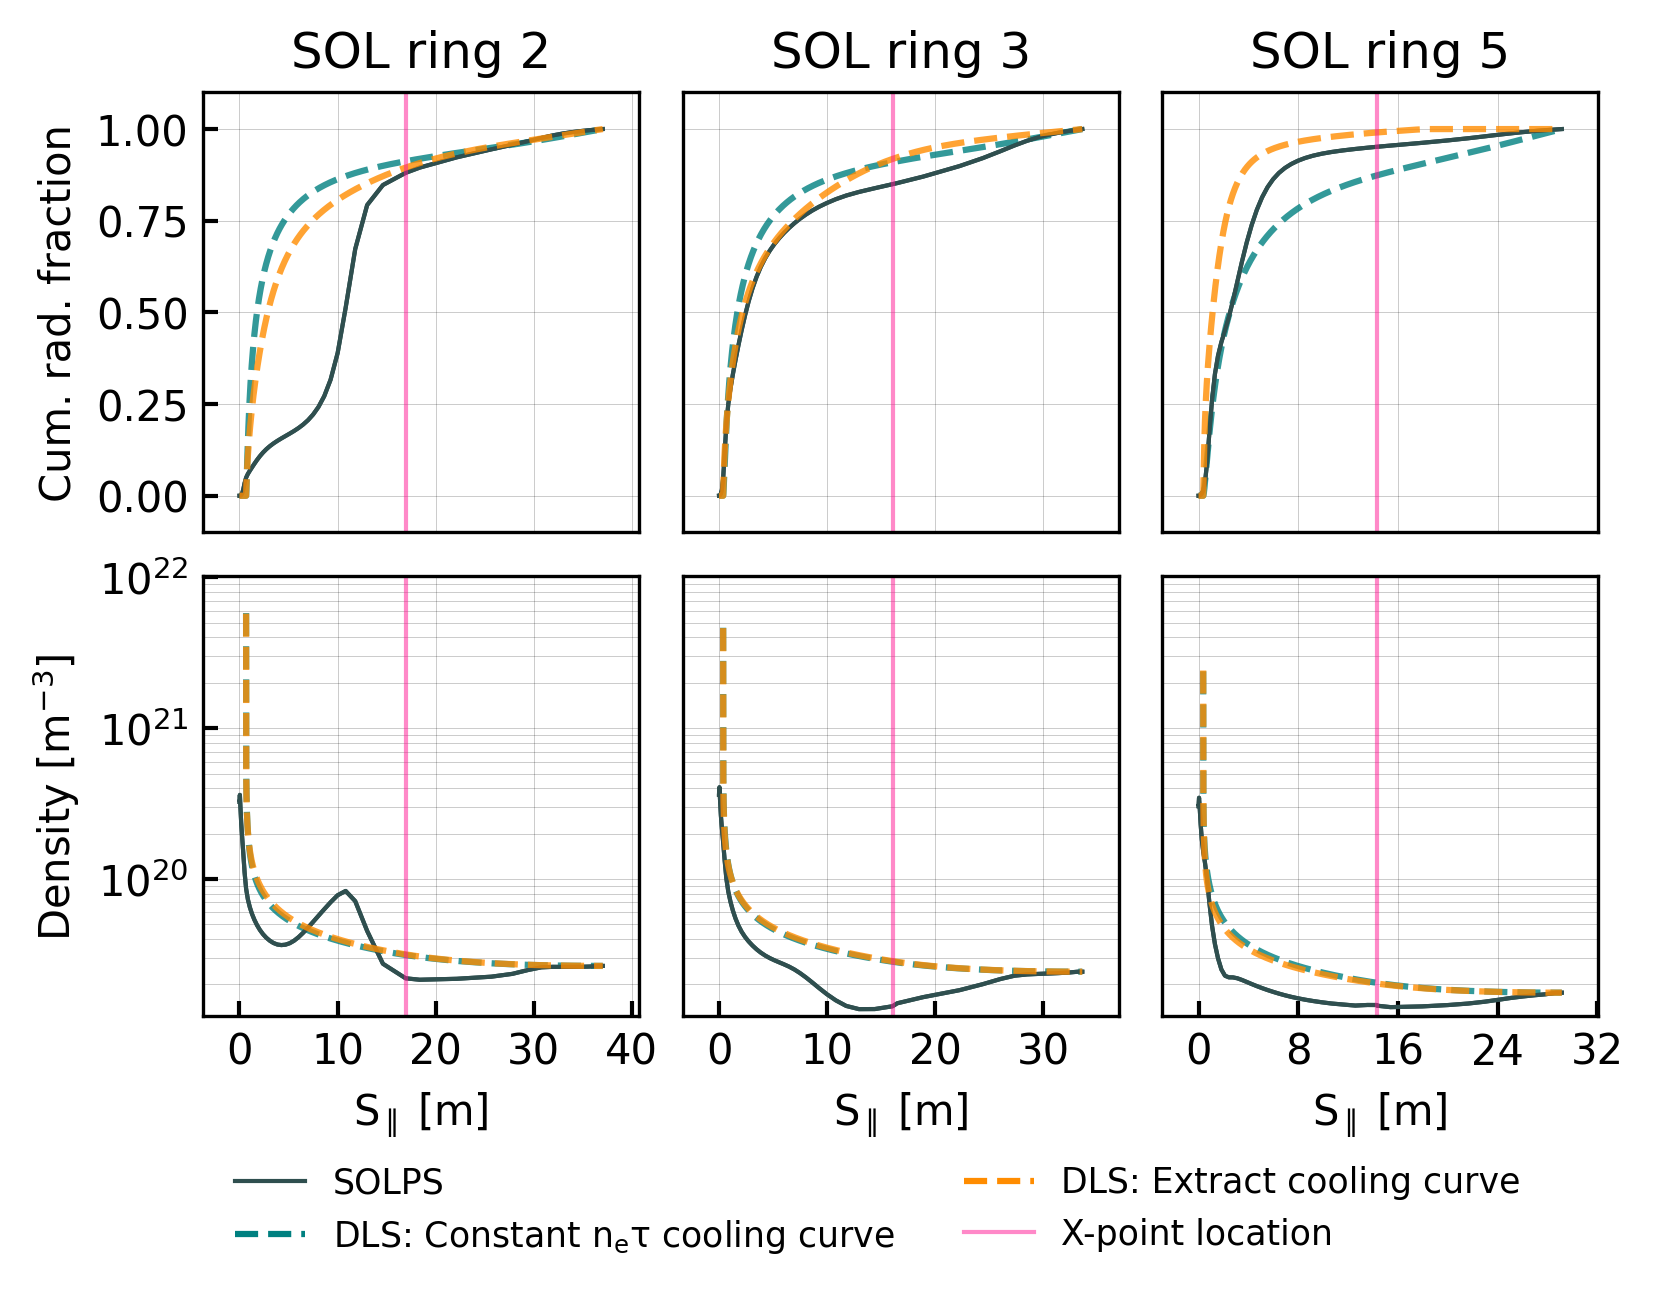

In [72]:
fig, axes = plt.subplots(2, 3, figsize = (6,4), dpi = 300, sharey = False)

study_choice = ['adas_curve', 'fit_curve']
pc = plot_comparison(comps_outer, studies = study_choice)
pc.plot("Prad_cum_norm", axes[0,:])
pc.plot("Ne", axes[1,:])

axes[0,0].set_title("SOL ring 2")
axes[0,1].set_title("SOL ring 3")
axes[0,2].set_title("SOL ring 5")

handles = pc.make_legend_elements()
handles_xpoint = [pc.make_legend_elements()[-1]]

for i in [1,2,3]:
    handles[i].set_label("DLS: " + handles[i].get_label())
handles[-1].set_label("X-point location")

axes[0,0].set_ylabel("Cum. rad. fraction")
axes[1,0].set_ylabel("Density [$m^{-3}$]")

for row in range(2):
    for col in [1,2]:
        axes[row, col].sharey(axes[row,0])
        axes[row, col].tick_params(axis="y", left = False, labelleft = False)
        axes[row, col].set_ylabel("")
        
for col in range(3):
    axes[0, col].set_xlabel("")
    axes[0, col].tick_params(axis = "x", bottom = False, labelbottom = False)
# axes[0,1].get_shared_y_axes().join(axes[0,0], axes[0,1])

voffset = 0.2
fig.legend(handles = handles, ncols = 2, bbox_to_anchor = (0.5, -0.2 + voffset), loc = "upper center", frameon = False, fontsize = "small")
# fig.legend(handles = handles_xpoint, ncols = 1, bbox_to_anchor = (0.073, -0.45 + voffset), loc = "upper left", frameon = False)
fig.subplots_adjust(wspace = 0.1)
fig.subplots_adjust(hspace = 0.1)

<>:19: SyntaxWarning: invalid escape sequence '\ '
<>:19: SyntaxWarning: invalid escape sequence '\ '


C:\Users\Mike\AppData\Local\Temp\ipykernel_17812\2036230078.py:19: SyntaxWarning: invalid escape sequence '\ '
  axes[0,4].set_title("$N_{e}^{2}f_{Ar}\ /\ N_{e,u}^{2}f_{Ar,u}$", fontsize = titlesize)


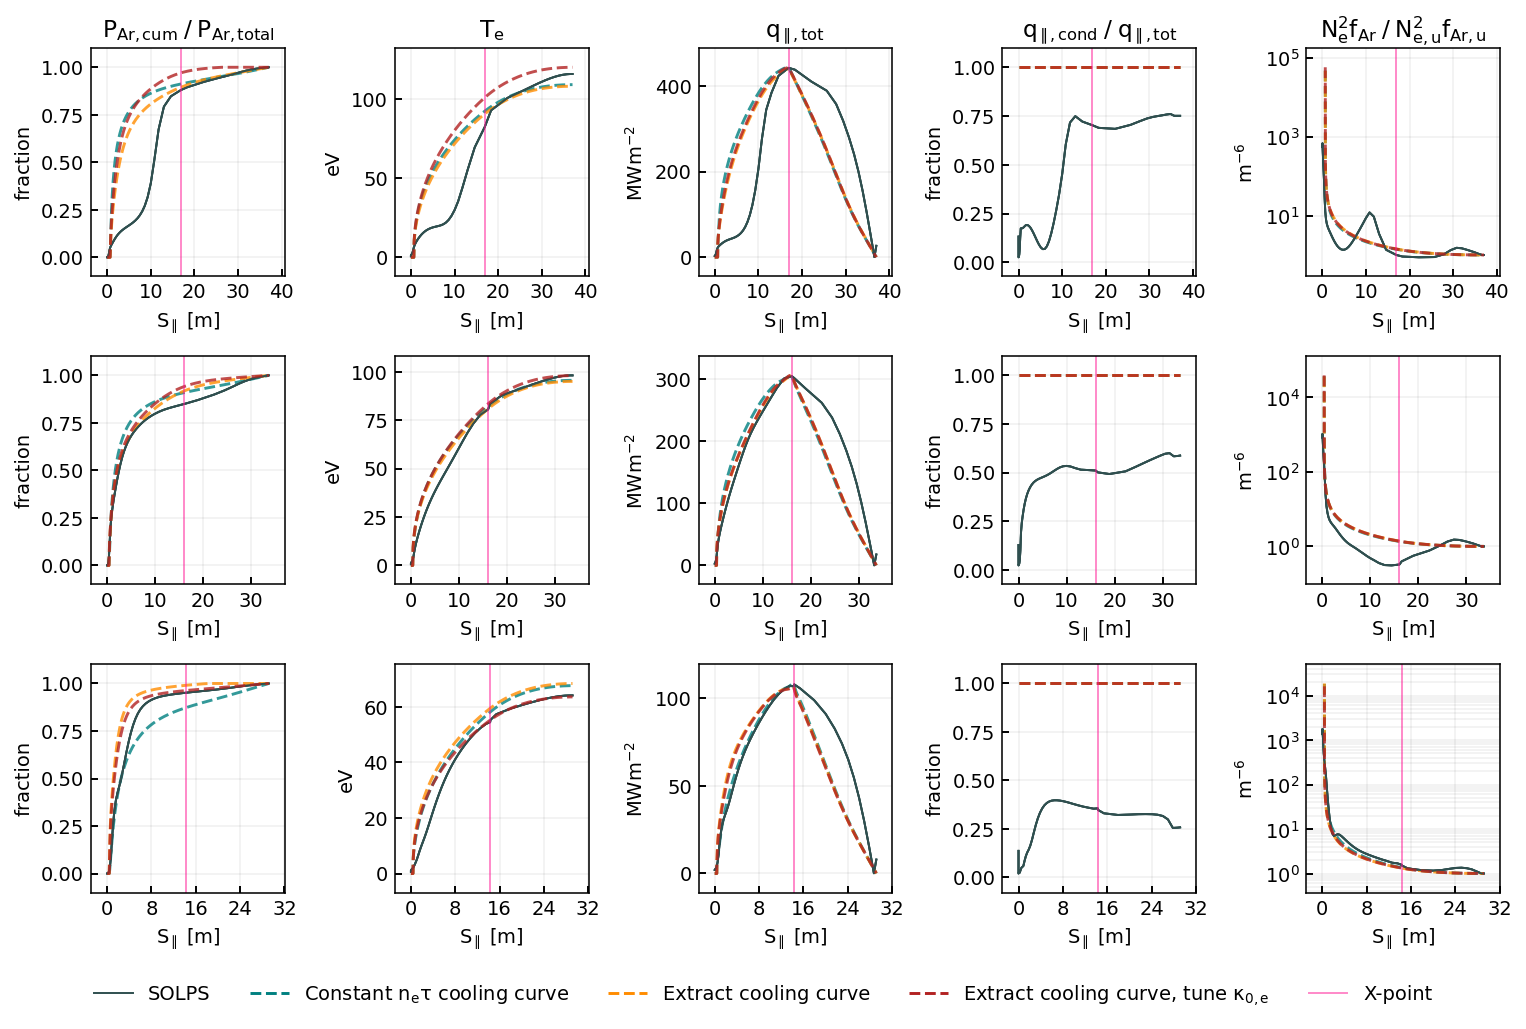

In [73]:
study_choice = ['adas_curve', 'fit_curve', 'fit_curve_kappa']
pc = plot_comparison(comps_outer, studies = study_choice)

param = "Te"

fig, axes = plt.subplots(3, 5, figsize = (11,7), sharey = False)

pc.plot("Prad_cum_norm", axes[:,0])
pc.plot("Te", axes[:,1])
pc.plot("qpar", axes[:,2])
pc.plot("qpar_cond_frac", axes[:,3])
pc.plot("Ne_sq_cz", axes[:,4], normalise = True)

titlesize = "large"
axes[0,0].set_title(r"$P_{Ar,cum}\ /\ P_{Ar,total}$", fontsize = titlesize)
axes[0,1].set_title(r"$T_e$", fontsize = titlesize)
axes[0,2].set_title(r"$q_{\parallel, tot}$", fontsize = titlesize)
axes[0,3].set_title(r"$q_{\parallel, cond}\ /\ q_{\parallel, tot}$", fontsize = titlesize)
axes[0,4].set_title("$N_{e}^{2}f_{Ar}\ /\ N_{e,u}^{2}f_{Ar,u}$", fontsize = titlesize)


fig.tight_layout()
fig.legend(handles = pc.make_legend_elements(), ncols = 2+len(study_choice), bbox_to_anchor = (0.5, 0), loc = "upper center", frameon = False)
# plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_DLSresults_outer.pdf", format = "pdf", bbox_inches = "tight")

# Run inner

In [74]:
comps_inner = {}

### With  ADAS curve

Solving...2.52...Complete in 3.5 seconds
  Hflux factor for sepadd 1: 1.09
Solving...0.81...Complete in 2.9 seconds
  Hflux factor for sepadd 2: 1.14
Solving...0.00...Complete in 2.4 seconds
  Hflux factor for sepadd 3: 1.13


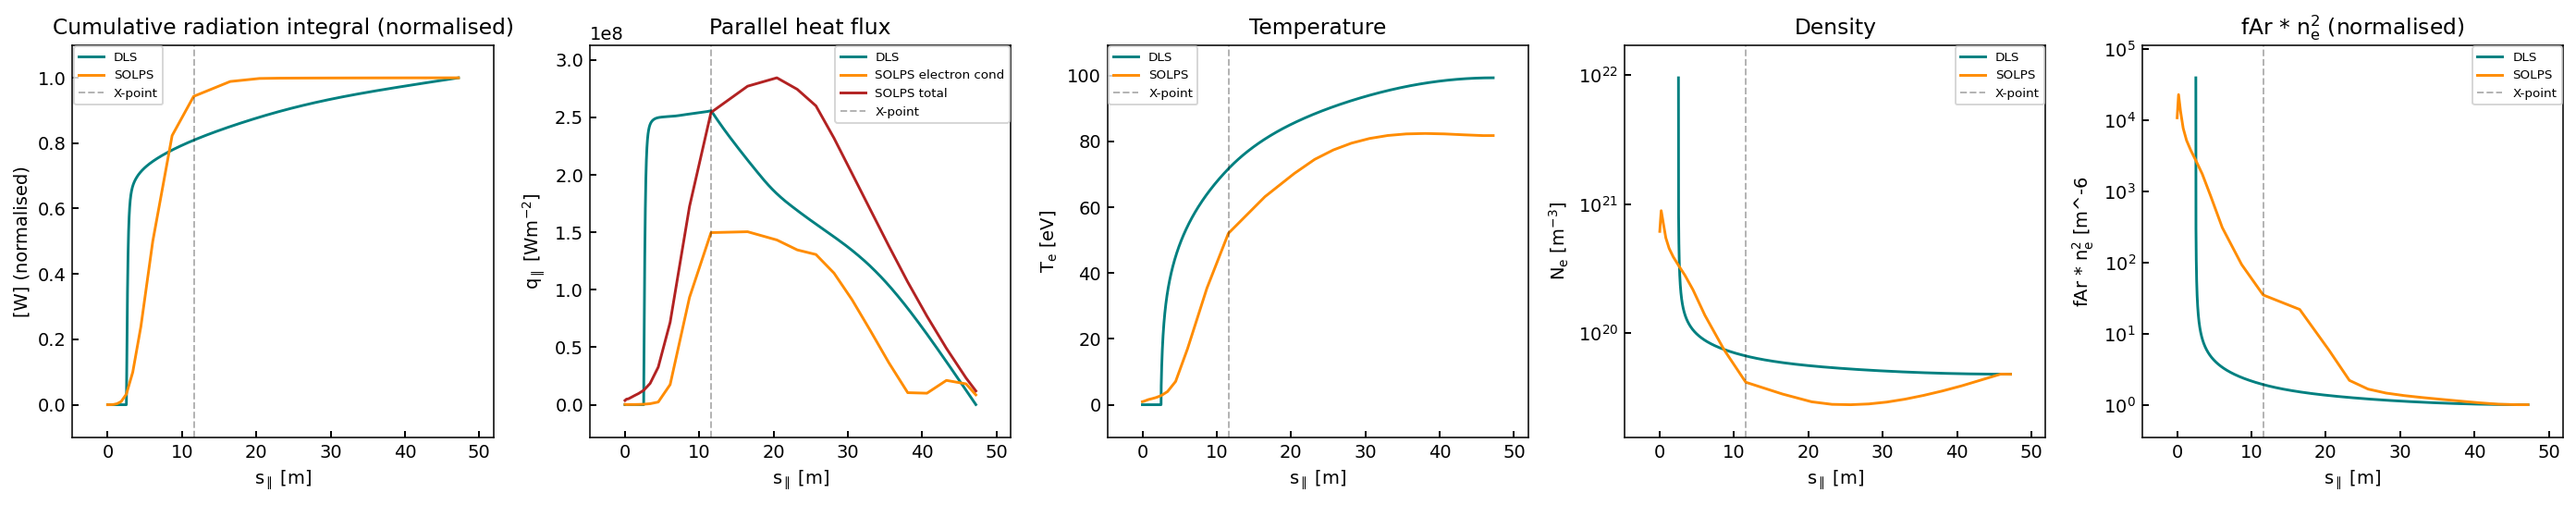

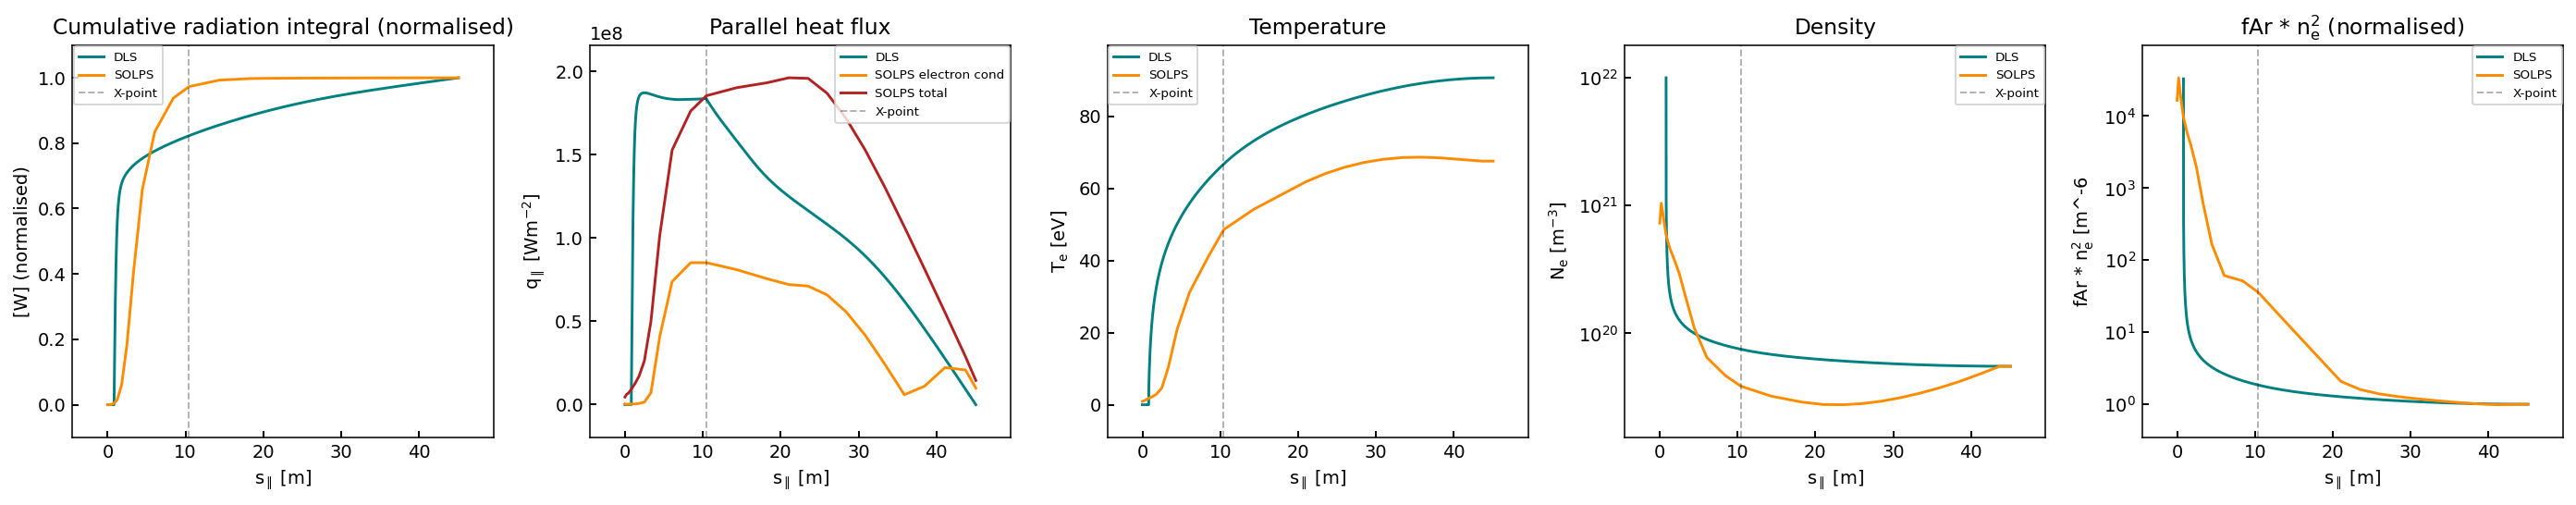

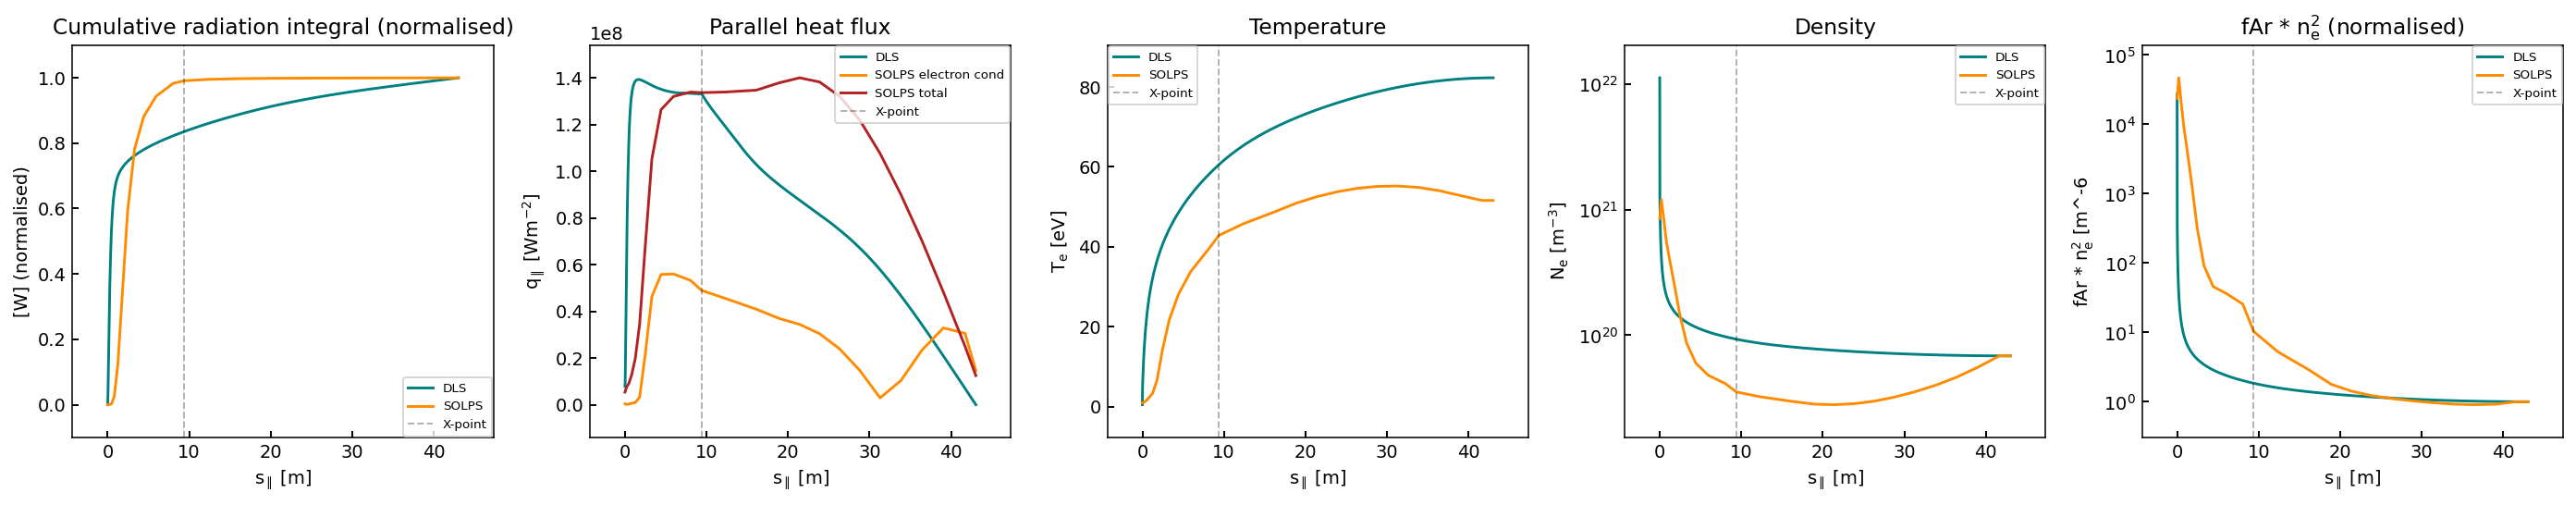

In [75]:
study = "adas_curve"
cvar = "impurity_frac"
region = "inner_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_inner[study] = {}

hflux_corrections = {0: 1, 1: 1.10, 2: 1.13, 3: 1.13, 4: 1.14}
kappa_corrections = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}

for i in [1,2,3]:
    input = {
        # "Lfunc" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "cooling_curve" : curves["Ar"][1e19],
        "kappa0" : 2500 * kappa_corrections[i],
    }

    comps_inner[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_inner[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False, legend_loc = "best")
    
    hflux_factor, kappa_factor = get_correction_factors(comps_inner[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### With fitted curve

Solving...2.52...Complete in 5.3 seconds
  Hflux factor for sepadd 1: 0.92
Solving...0.81...Complete in 2.1 seconds
  Hflux factor for sepadd 2: 0.95
Solving...0.00...Complete in 3.8 seconds
  Hflux factor for sepadd 3: 0.95


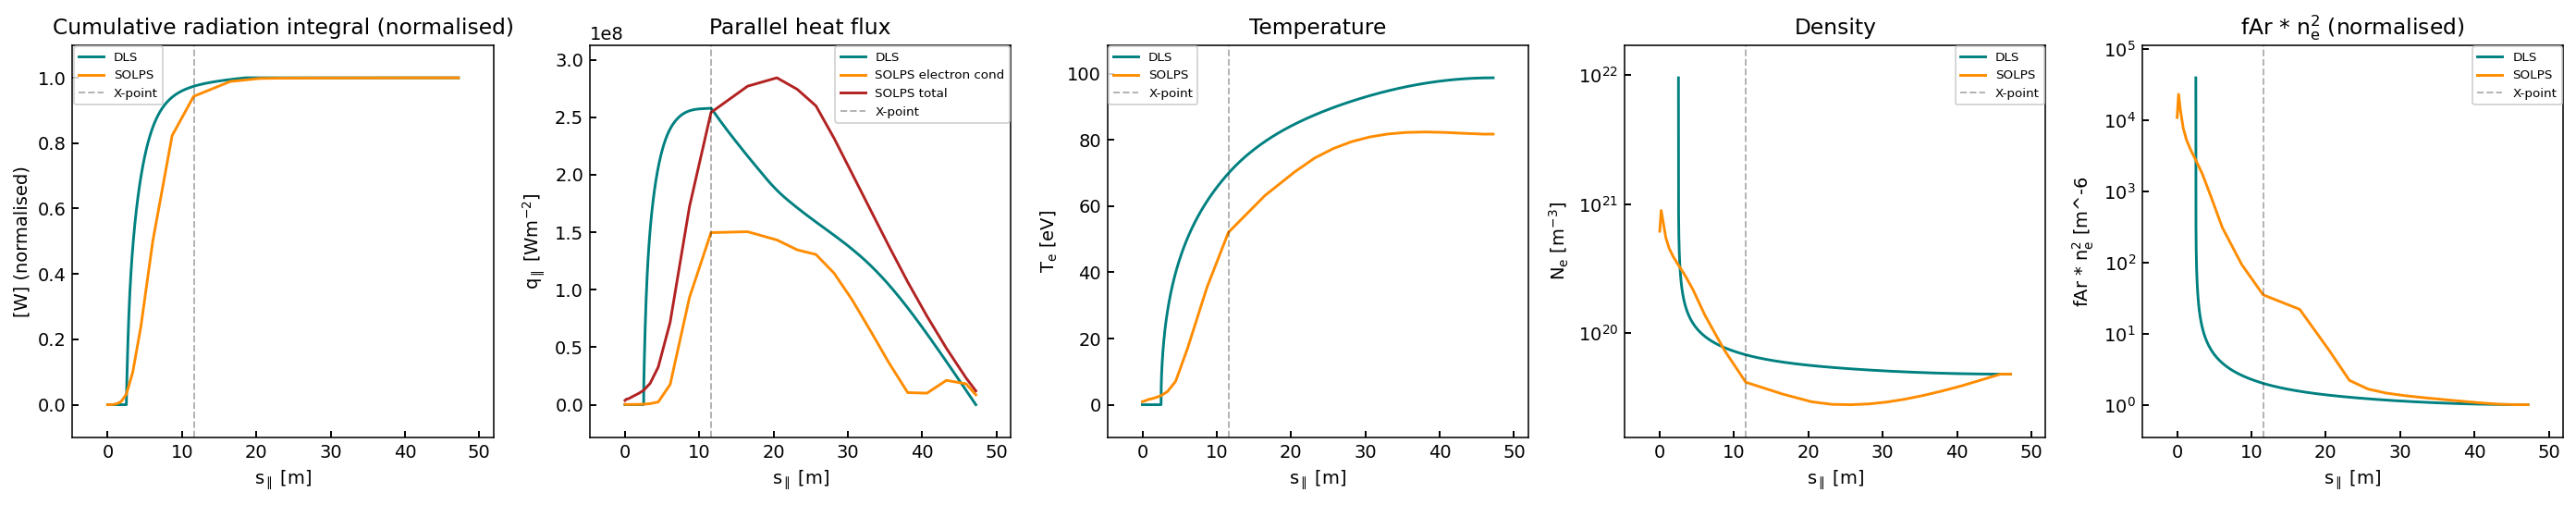

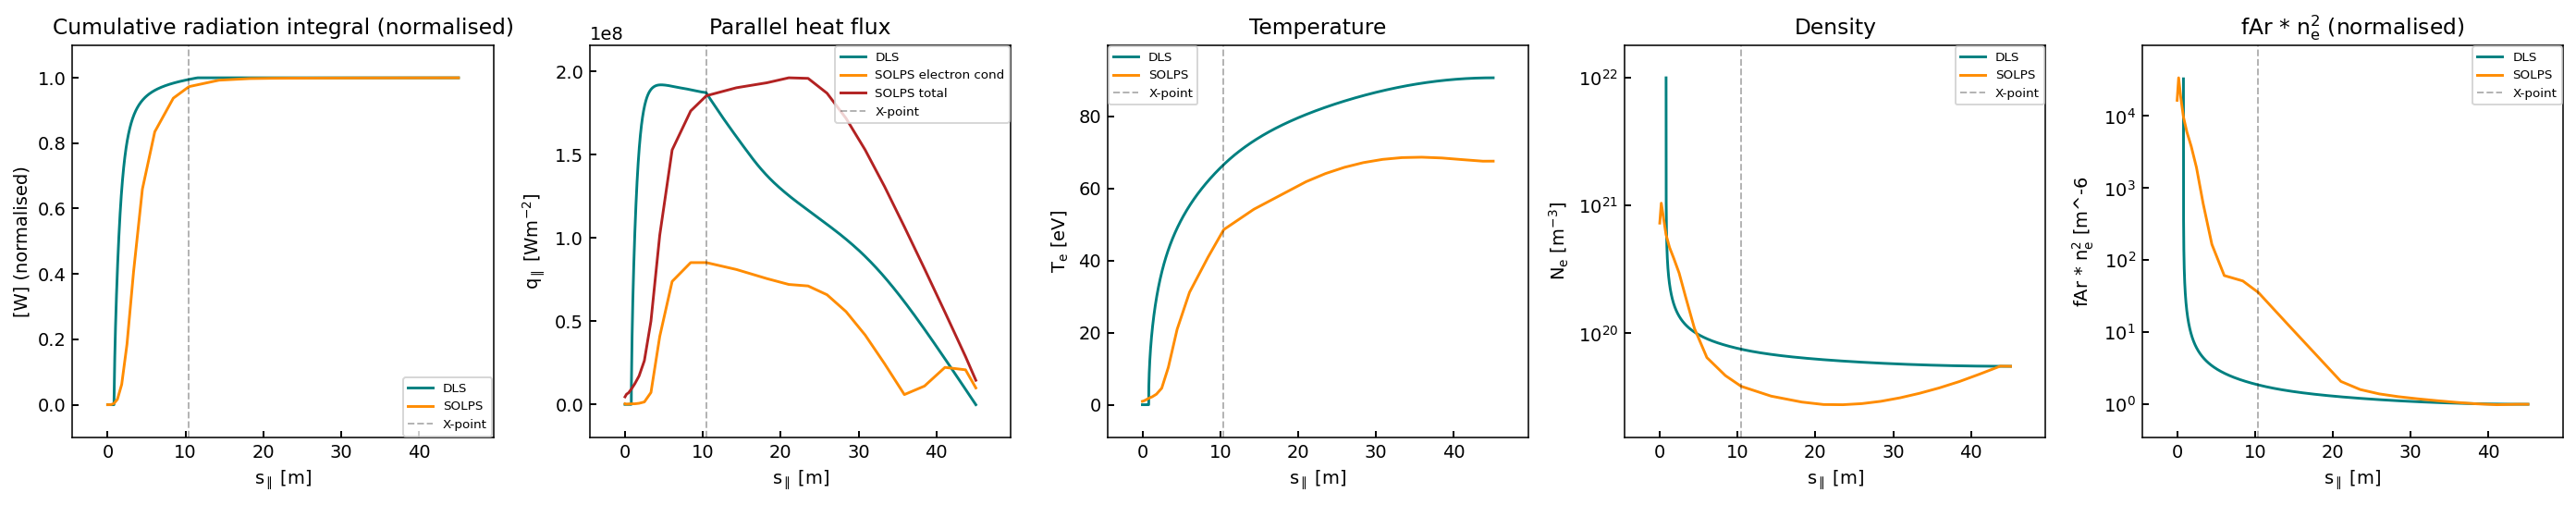

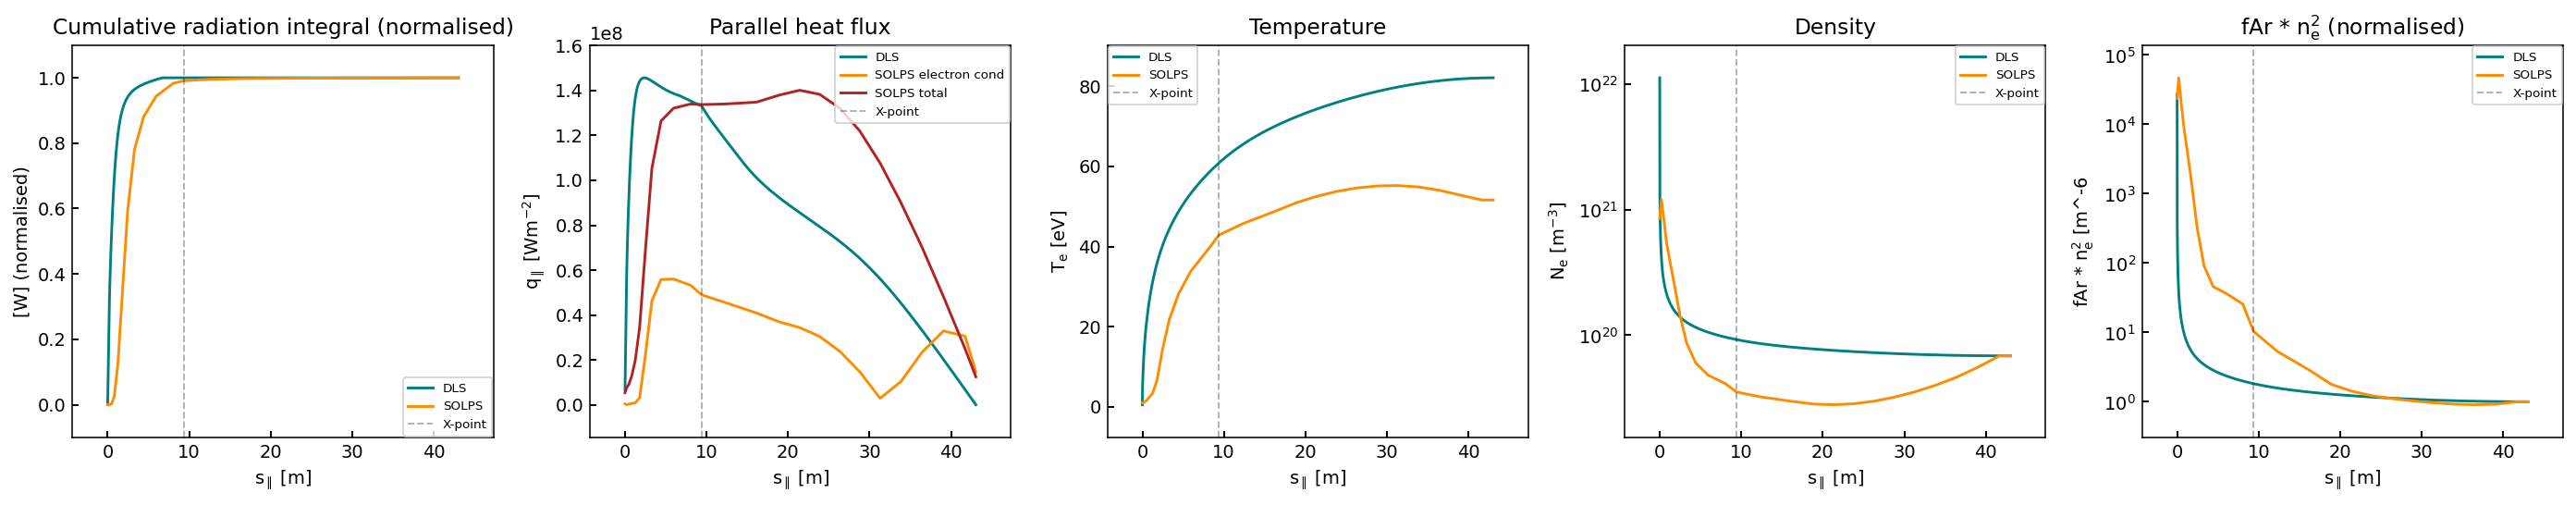

In [76]:
study = "fit_curve"
cvar = "impurity_frac"
region = "inner_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_inner[study] = {}

hflux_corrections = {0: 1, 1: 0.93, 2: 0.96, 3: 0.95, 4: 0.8}
kappa_corrections = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}

for i in [1,2,3]:
    input = {
        "cooling_curve" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "kappa0" : 2500 * kappa_corrections[i],
    }
    
    comps_inner[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_inner[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False, legend_loc = "best")

    hflux_factor, kappa_factor = get_correction_factors(comps_inner[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### Fit curve, kappa

Solving...2.52...Complete in 5.7 seconds
  Hflux factor for sepadd 1: 0.98
  Kappa factor for sepadd 1: 1.79
Solving...0.81...Complete in 3.4 seconds
  Hflux factor for sepadd 2: 1.02
  Kappa factor for sepadd 2: 2.51
Solving...0.00...Complete in 3.0 seconds
  Hflux factor for sepadd 3: 1.02
  Kappa factor for sepadd 3: 3.70


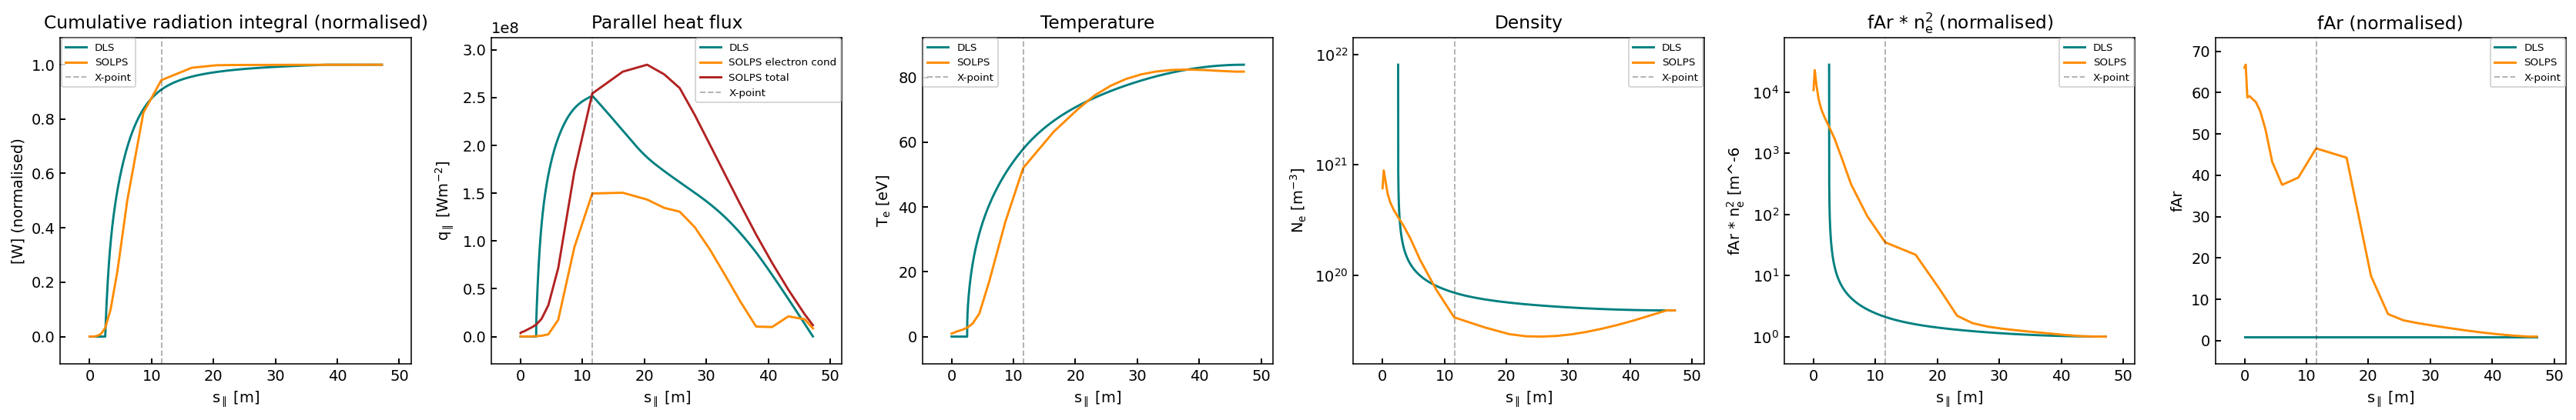

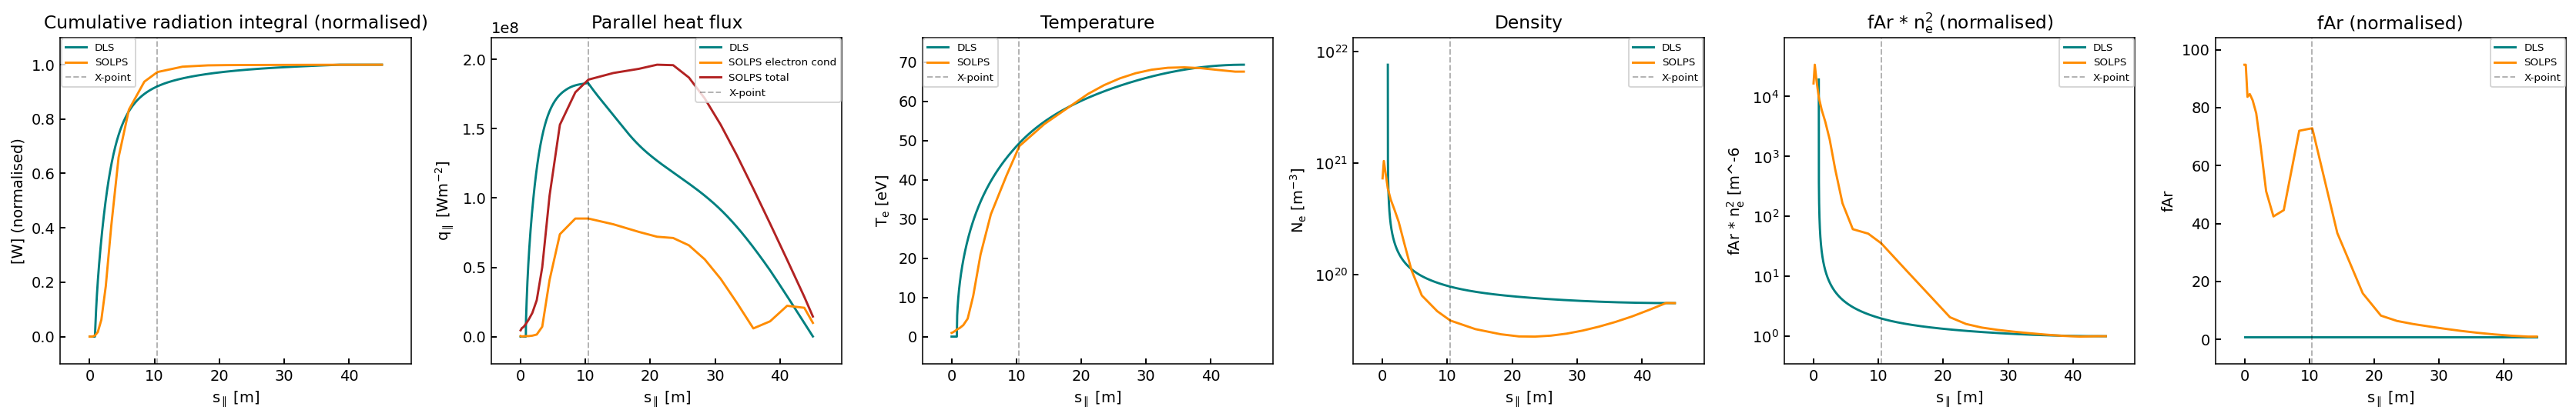

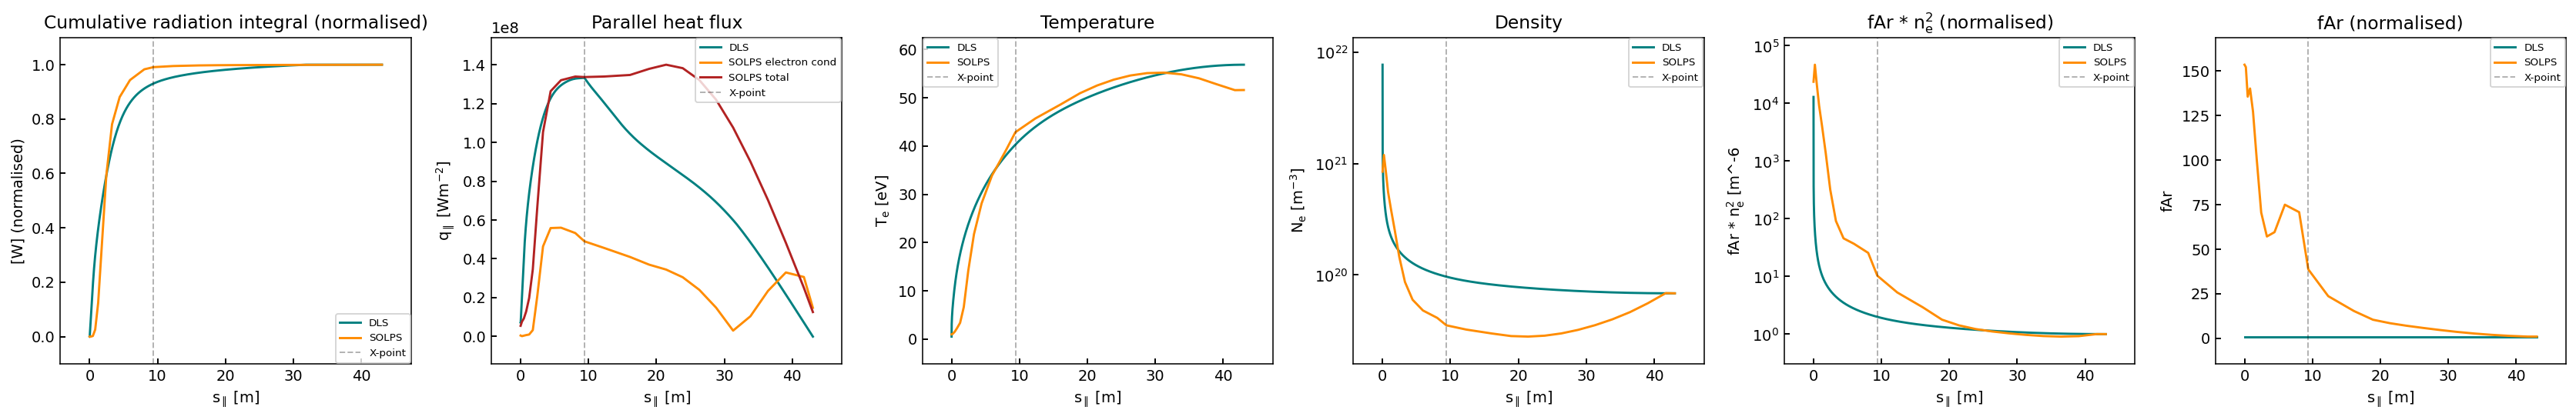

In [78]:
study = "fit_curve_kappa"
cvar = "impurity_frac"
region = "inner_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_inner[study] = {}

hflux_corrections = {0: 1, 1: 0.97, 2: 1.01, 3: 1.02, 4: 0.8}
kappa_corrections = {0: 1.13, 1: 1.73, 2: 2.46, 3: 3.49, 4: 3.59}

for i in [1,2,3]:
    input = {
        "cooling_curve" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "kappa0" : 2500 * kappa_corrections[i],
    }

    comps_inner[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_inner[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz", "cz"], normalise_radiation = True, radiation_per_area = False, legend_loc = "best")
    
    hflux_factor, kappa_factor = get_correction_factors(comps_inner[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")
    print(f"  Kappa factor for sepadd {i}: {kappa_factor * kappa_corrections[i]:.2f}")


## Plot inner

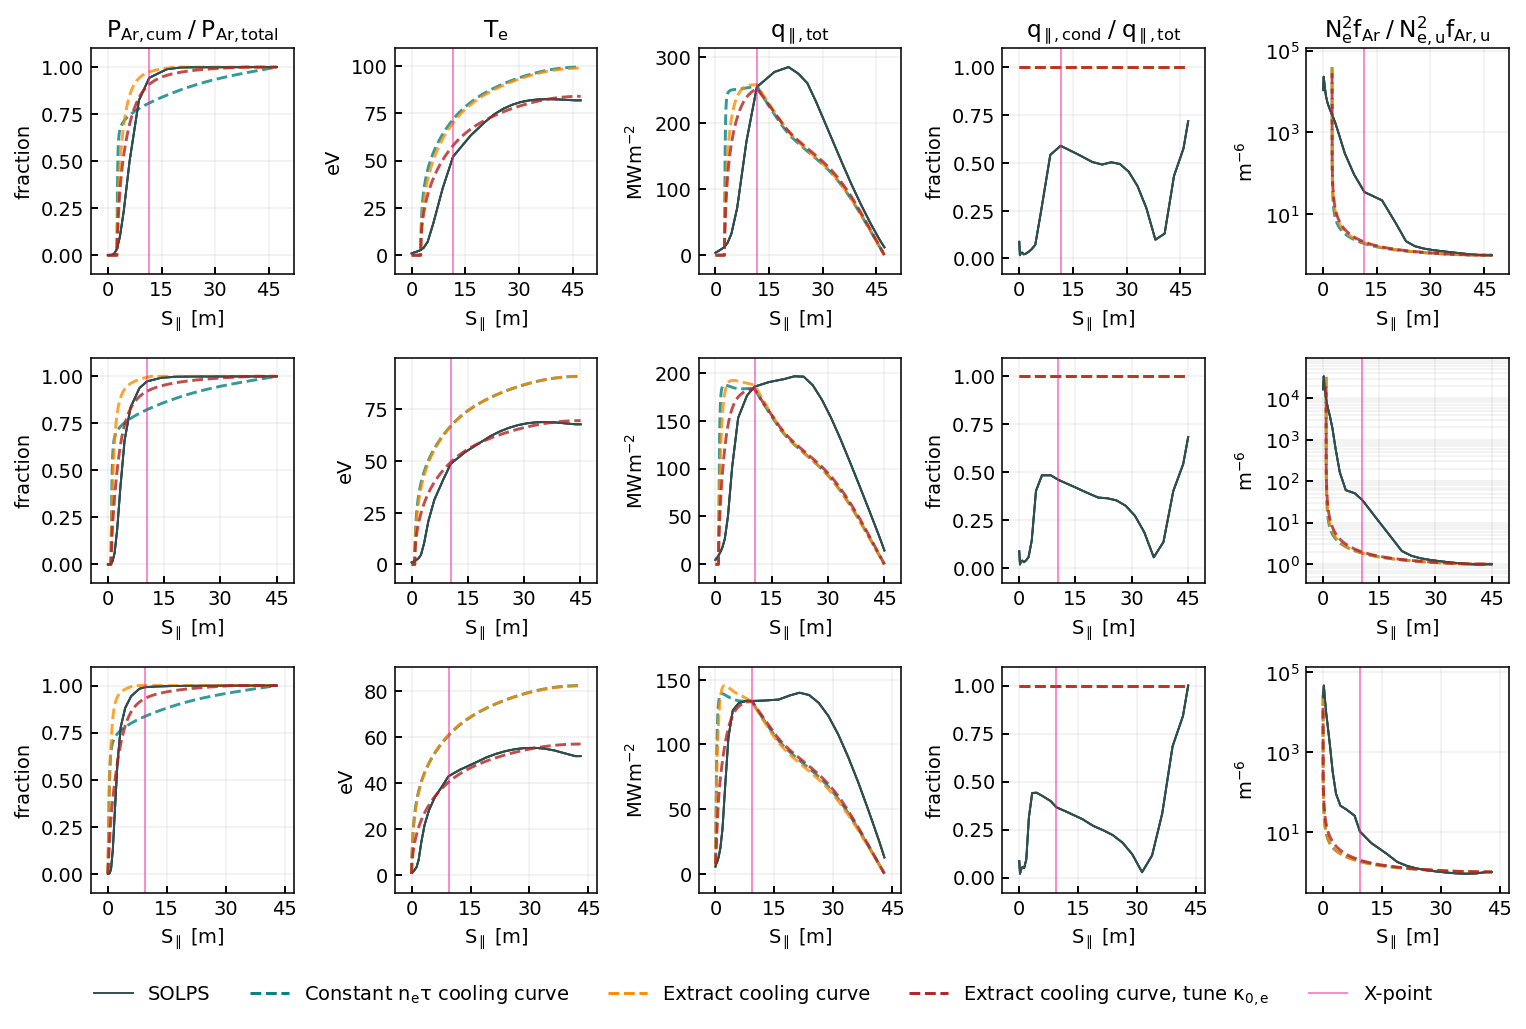

In [80]:
study_choice = ['adas_curve', 'fit_curve', 'fit_curve_kappa']
pc = plot_comparison(comps_inner, studies = study_choice)

param = "Te"

fig, axes = plt.subplots(3, 5, figsize = (11,7), sharey = False)

pc.plot("Prad_cum_norm", axes[:,0])
pc.plot("Te", axes[:,1])
pc.plot("qpar", axes[:,2])
pc.plot("qpar_cond_frac", axes[:,3])
pc.plot("Ne_sq_cz", axes[:,4], normalise = True)

titlesize = "large"
axes[0,0].set_title(r"$P_{Ar,cum}\ /\ P_{Ar,total}$", fontsize = titlesize)
axes[0,1].set_title(r"$T_e$", fontsize = titlesize)
axes[0,2].set_title(r"$q_{\parallel, tot}$", fontsize = titlesize)
axes[0,3].set_title(r"$q_{\parallel, cond}\ /\ q_{\parallel, tot}$", fontsize = titlesize)
axes[0,4].set_title(r"$N_{e}^{2}f_{Ar}\ /\ N_{e,u}^{2}f_{Ar,u}$", fontsize = titlesize)

fig.tight_layout()
fig.legend(handles = pc.make_legend_elements(), ncols = 2+len(study_choice), bbox_to_anchor = (0.5, 0), loc = "upper center", frameon = False)
# plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_DLSresults_inner.pdf", format = "pdf", bbox_inches = "tight")